# VarnaAir - Open Programme

## Introduction ℹ️
VarnaAir is a machine learning project focused on predicting the Air Quality Index (AQI) for Varna, Bulgaria. The project applies regression models to forecast AQI levels.

I chose Varna for this project because it is my hometown and I deeply care about the environmental impact of air pollution. As a coastal city, Varna faces significant pollution from its seaport, as well as from the airport and increasing traffic levels. 

More importantly, it is where my family and friends live, so their health and well-being are a strong personal motivation behind this project.


## Libraries 📚
First, let's begin by importing the libraries and checking their versions.

In [ ]:
import numpy
import pandas
import sklearn
import seaborn
import requests
import datetime
from pytz import timezone
from sklearn.svm import SVR
from datetime import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, RandomForestRegressor, StackingRegressor, AdaBoostRegressor, BaggingRegressor

print("Library versions:")
print("- numpy:", numpy.__version__)                #2.1.3
print("- pandas:", pandas.__version__)              #2.2.3
print("- sklearn:", sklearn.__version__)            #1.6.1
print("- seaborn:", seaborn.__version__)            #0.13.1
print("- requests:", requests.__version__)          #2.31.0
print("- matplotlib:", plt.matplotlib.__version__)  #3.10.0

Library versions:
- numpy: 2.1.3
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2
- requests: 2.31.0
- matplotlib: 3.10.0


## Data provisioning 📦

Next, we will use a free to use API key provided by Air Pollution API [https://openweathermap.org/api/air-pollution].

Besides basic Air Quality Index, the API returns data about polluting gases, such as Carbon monoxide (CO), Nitrogen monoxide (NO), Nitrogen dioxide (NO2), Ozone (O3), Sulphur dioxide (SO2), Ammonia (NH3) and particulates (PM2.5 and PM10).

The data spans from January 1, 2023 (00:00:00 Europe/Sofia's timezone) to June 28, 2025 (00:00:00 Europe/Sofia's timezone) as of today.

Varna shares the same time zone as the capital city - Sofia.

In [161]:
sofia_tz = timezone("Europe/Sofia")

start_date = datetime(2023, 1, 1, 0, 0, 0, tzinfo=sofia_tz)   # January 1, 2023, 00:00:00 Sofia time
end_date = datetime(2025, 6, 28, 0, 0, 0, tzinfo=sofia_tz)    # June 28, 2025, 00:00:00 Sofia time

start = int(start_date.timestamp())
end = int(end_date.timestamp())

print("Start timestamp:", start)
print("End timestamp:", end)

Start timestamp: 1672525620
End timestamp: 1751063220


The API call "Historical air pollution data" I am using is:

`http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={API key}`

In order to explain the request, I will explain each query parameters:
- lat: 43.224389 corresponds to the latitude of Varna, Bulgaria.
- lon: 27.915733 corresponds to the longitude of Varna, Bulgaria.
- start: 1672525620 corresponds to January 1, 2023, 00:00:00 Sofia time.
- end: 1751063220 corresponds to June 28, 2025, 00:00:00 Sofia time.
- appid: 6964febcb17ba6ff6b81e9dc9f05d7cc is my API key, which authenticates the request with the OpenWeatherMap API.

In [162]:
url = "http://api.openweathermap.org/data/2.5/air_pollution/history?lat=43.224389&lon=27.915733&start=1672525620&end=1751063220&appid=6964febcb17ba6ff6b81e9dc9f05d7cc"

response = requests.get(url)

data = response.json()
data_list = data.get("list", [])

df = pandas.json_normalize(data_list)
df["dt"] = pandas.to_datetime(df["dt"], unit="s").dt.tz_localize("UTC").dt.tz_convert(sofia_tz)

df

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
0,2023-01-01 01:00:00+02:00,2.0,337.12,0.16,18.34,12.16,2.38,21.40,24.74,0.17
1,2023-01-01 02:00:00+02:00,2.0,300.41,0.05,14.74,18.78,2.26,17.98,20.54,0.13
2,2023-01-01 03:00:00+02:00,2.0,283.72,0.01,11.48,28.61,2.18,15.54,17.46,0.09
3,2023-01-01 04:00:00+02:00,2.0,280.38,0.01,10.11,30.76,2.12,14.57,16.24,0.09
4,2023-01-01 05:00:00+02:00,2.0,283.72,0.01,9.51,31.47,2.15,14.03,15.58,0.10
...,...,...,...,...,...,...,...,...,...,...
21331,2025-06-27 21:00:00+03:00,2.0,108.72,0.00,1.27,86.86,0.94,5.25,6.22,1.01
21332,2025-06-27 22:00:00+03:00,2.0,109.85,0.00,1.38,81.64,1.04,5.09,6.00,1.12
21333,2025-06-27 23:00:00+03:00,2.0,111.90,0.00,1.58,75.80,1.09,5.00,5.90,1.31
21334,2025-06-28 00:00:00+03:00,2.0,113.24,0.00,1.71,70.80,1.08,4.85,5.73,1.48


Since the winter is +2:00 UTC and the summer is +3:00 there is some differences in the format of the datetimein in the beginning and the end.

To enhance readability and ensure clarity, we will rename the columns to make them more descriptive and consistent.

In [163]:
df.rename(columns={"dt": "datetime_local", 
                   "main.aqi": "AQI",
                   "components.co": "CO",
                   "components.no": "NO",
                   "components.no2": "NO2",
                   "components.o3": "O3",
                   "components.so2": "SO2",
                   "components.pm2_5": "PM2_5",
                   "components.pm10": "PM10",
                   "components.nh3": "NH3"}, inplace=True)
df

,datetime_local,AQI,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3
0,2023-01-01 01:00:00+02:00,2.0,337.12,0.16,18.34,12.16,2.38,21.40,24.74,0.17
1,2023-01-01 02:00:00+02:00,2.0,300.41,0.05,14.74,18.78,2.26,17.98,20.54,0.13
2,2023-01-01 03:00:00+02:00,2.0,283.72,0.01,11.48,28.61,2.18,15.54,17.46,0.09
3,2023-01-01 04:00:00+02:00,2.0,280.38,0.01,10.11,30.76,2.12,14.57,16.24,0.09
4,2023-01-01 05:00:00+02:00,2.0,283.72,0.01,9.51,31.47,2.15,14.03,15.58,0.10
...,...,...,...,...,...,...,...,...,...,...
21331,2025-06-27 21:00:00+03:00,2.0,108.72,0.00,1.27,86.86,0.94,5.25,6.22,1.01
21332,2025-06-27 22:00:00+03:00,2.0,109.85,0.00,1.38,81.64,1.04,5.09,6.00,1.12
21333,2025-06-27 23:00:00+03:00,2.0,111.90,0.00,1.58,75.80,1.09,5.00,5.90,1.31
21334,2025-06-28 00:00:00+03:00,2.0,113.24,0.00,1.71,70.80,1.08,4.85,5.73,1.48


## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the key variables used in this dataset:

| No. | Column Name     | Unit     | Description                                                          | Good    | Moderate  | Bad                  |
|-----|-----------------|----------|----------------------------------------------------------------------|---------|-----------|----------------------|
| 1   | datetime_local  | datetime | Local date and time of the air quality measurement.                  |    -    |     -     |   -                  |
| 2   | AQI             | 1-5      | Air Quality Index value calculated based on pollutant concentrations.|1-2(Good)|3(Moderate)|4-5(Poor to Very Poor)|
| 3   | CO              | µg/m³    | Concentration of carbon monoxide (CO).                               |0-500    |501-1000	|>1000                 |
| 4   | NO              | µg/m³    | Concentration of nitrogen monoxide (NO).                             |0-0.2    |0.21-0.5   |>0.5                  |
| 5   | NO2             | µg/m³    | Concentration of nitrogen dioxide (NO₂).                             |0-20     |21-40  	|>40                   |
| 6   | O3              | µg/m³    | Concentration of ozone (O₃).                                         |0-50     |51-1000	|>100                  |
| 7   | SO2             | µg/m³    | Concentration of sulfur dioxide (SO₂).                               |0-5      |6-10    	|>10                   |
| 8   | PM2_5           | µg/m³    | Concentration of particulate matter with diameter ≤ 2.5 µm (PM₂.₅).  |0-25     |26-50  	|>50                   |
| 9   | PM10            | µg/m³    | Concentration of particulate matter with diameter ≤ 10 µm (PM₁₀).    |0-50     |51-100 	|>100                  |
| 10  | NH3             | µg/m³    | Concentration of ammonia (NH₃).                                      |0-0.5    |0.6-1  	|>1                    |

To better understand each value, I will explain them one by one:

**AQI (Air Quality Index)**
- The AQI is a standardized tool used to communicate how polluted the air currently is or how polluted it is forecast to become. It converts complex air quality data into a single number and category for ease of understanding.
- The AQI is calculated based on the concentrations of key pollutants. Each pollutant's concentration is mapped to an index value using pollutant-specific breakpoints defined by local or international standards.
- *Categories:*
    - **1 (Good):** Air quality poses no risk, and pollution levels are low.
    - **2 (Fair):** Air quality is satisfactory, with little or no risk to health.
    - **3 (Moderate):** Air quality is acceptable, but there may be a concern for some individuals who are particularly sensitive to air pollution.
    - **4 (Poor):** Health effects may be felt by everyone. Members of sensitive groups may experience more serious effects.
    - **5 (Very Poor):** Serious health effects for everyone, with greater risks for sensitive groups. Prolonged exposure should be avoided.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, potentially causing dizziness, confusion, or even fatality at very high levels.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Not directly harmful in most cases but quickly reacts to form NO₂, which has more significant health impacts.

**NO₂ (Nitrogen Dioxide)**
- Key indicator of traffic-related air pollution.
- Formed primarily from the burning of fossil fuels in vehicles (cars, trucks, etc) and power plants.
- Irritates airways, reduces lung function and increases the risk of respiratory infections.
- Contributes to the formation of ozone (O₃) and particulate matter (PM2.5, PM10).

**O₃ (Ground-level Ozone)**
- A secondary pollutant formed from the reaction of sunlight with NOx and VOCs (volatile organic compounds).
- Causes chest pain, coughing, throat irritation and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**PM2.5 (Fine Particulate Matter ≤ 2.5 µm)**
- A major component of AQI calculations and a critical indicator of air quality.
- Very small particles that can penetrate deep into the lungs and enter the bloodstream.
- Linked to respiratory and cardiovascular diseases, cancer and premature death.

**PM10 (Particulate Matter ≤ 10 µm)**
- Larger than PM2.5 but still small enough to enter the respiratory system.
- Causes respiratory irritation, worsens asthma and can lead to chronic lung diseases.
- Often associated with dust, pollen and other coarser particles.

**NH₃ (Ammonia)**
- Released from agricultural activities, such as livestock farming and fertilizer use.
- Reacts with other pollutants to form PM2.5, indirectly affecting respiratory and cardiovascular health.
- Direct exposure to high concentrations can cause irritation of the eyes, nose and throat and may exacerbate respiratory issues.
- While not typically a direct health threat at outdoor levels, its role in forming secondary particulate matter makes it an important factor in air quality management.

### Sample the data 📃
Let's sample the data to check how it looks so far before the preprocessing.

In [164]:
df.sample(10)

,datetime_local,AQI,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3
232,2023-01-10 17:00:00+02:00,2.0,287.06,0.01,15.94,67.95,11.56,18.20,20.89,1.01
16597,2024-12-02 14:00:00+02:00,2.0,250.34,0.06,2.48,77.96,0.84,0.86,1.11,0.11
19207,2025-03-23 08:00:00+02:00,2.0,247.00,0.02,1.46,97.27,1.61,5.04,5.75,0.34
4580,2023-07-13 22:00:00+03:00,3.0,257.02,0.00,4.63,123.02,3.31,39.48,42.55,0.00
16907,2024-12-15 12:00:00+02:00,2.0,283.72,0.68,3.98,63.66,1.88,3.13,4.01,0.31
15194,2024-10-05 04:00:00+03:00,3.0,230.31,0.00,3.81,59.37,1.88,26.59,36.07,0.00
1193,2023-02-19 18:00:00+02:00,2.0,260.35,0.00,6.08,84.40,2.80,7.36,8.40,1.35
14361,2024-08-30 11:00:00+03:00,1.0,320.43,0.04,2.08,50.07,0.45,6.95,7.05,0.13
14315,2024-08-28 13:00:00+03:00,3.0,290.39,0.29,2.68,101.57,1.89,17.74,19.57,0.56
20035,2025-05-04 21:00:00+03:00,2.0,119.82,0.00,2.17,88.31,1.60,8.28,9.14,2.02


## Preprocessing 🛠️
Machine learning models learn patterns from the data they are given. If the data contains noise, inconsistencies or errors (e.g. typos, null values, duplicates), the model will likely learn misleading or irrelevant patterns - leading to poor performance and unreliable predictions. To prevent this, it is essential to check all rows that contain missing data. If such rows exist, a decision should be made about whether to remove them.
### Null values 0️⃣

In [165]:
df.isnull().sum()

datetime_local    0
AQI               0
CO                0
NO                0
NO2               0
O3                0
SO2               0
PM2_5             0
PM10              0
NH3               0
dtype: int64

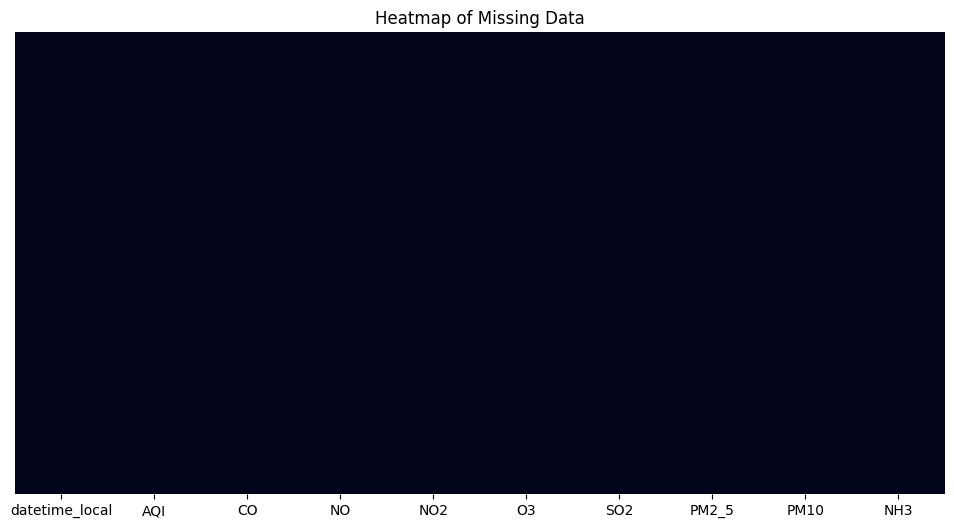

In [166]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(df.isnull(), cbar=False, cmap="rocket", yticklabels=False)
plt.title("Heatmap of Missing Data")
plt.show()

The dataset contains no missing values, so no imputation or removal is required. 

In [167]:
df.dtypes

datetime_local    datetime64[ns, Europe/Sofia]
AQI                                    float64
CO                                     float64
NO                                     float64
NO2                                    float64
O3                                     float64
SO2                                    float64
PM2_5                                  float64
PM10                                   float64
NH3                                    float64
dtype: object

There is also no wrong datatypes.

### Duplicates 👯‍♂️
Although the dataset is sourced from a reliable API, it is good practice to verify that there are no duplicate datetime entries to ensure data integrity

In [168]:
num_duplicate_dt = df.duplicated(subset=["datetime_local"]).sum()
num_duplicate_all = df.duplicated().sum()

print(f"Number of duplicate timestamps: {num_duplicate_dt}")
print(f"Number of fully duplicate rows: {num_duplicate_all}")

Number of duplicate timestamps: 0
Number of fully duplicate rows: 0


### Format dates 🗓️
Breaking down the datetime into components like year, month, day, hour and weekday helps analyze time-based AQI patterns. It enables detection of seasonal trends, daily/hourly pollution spikes, and weekday vs. weekend differences. These features are crucial for creating lagging variables, modeling temporal dependencies, grouping data, and understanding how time-sensitive factors influence air quality.

In [169]:
df["year"] = df["datetime_local"].dt.year
df["month"] = df["datetime_local"].dt.month
df["day"] = df["datetime_local"].dt.day
df["hour"] = df["datetime_local"].dt.hour
df["weekday"] = df["datetime_local"].dt.weekday + 1  # Monday=1

df

,datetime_local,AQI,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,year,month,day,hour,weekday
0,2023-01-01 01:00:00+02:00,2.0,337.12,0.16,18.34,12.16,2.38,21.40,24.74,0.17,2023,1,1,1,7
1,2023-01-01 02:00:00+02:00,2.0,300.41,0.05,14.74,18.78,2.26,17.98,20.54,0.13,2023,1,1,2,7
2,2023-01-01 03:00:00+02:00,2.0,283.72,0.01,11.48,28.61,2.18,15.54,17.46,0.09,2023,1,1,3,7
3,2023-01-01 04:00:00+02:00,2.0,280.38,0.01,10.11,30.76,2.12,14.57,16.24,0.09,2023,1,1,4,7
4,2023-01-01 05:00:00+02:00,2.0,283.72,0.01,9.51,31.47,2.15,14.03,15.58,0.10,2023,1,1,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21331,2025-06-27 21:00:00+03:00,2.0,108.72,0.00,1.27,86.86,0.94,5.25,6.22,1.01,2025,6,27,21,5
21332,2025-06-27 22:00:00+03:00,2.0,109.85,0.00,1.38,81.64,1.04,5.09,6.00,1.12,2025,6,27,22,5
21333,2025-06-27 23:00:00+03:00,2.0,111.90,0.00,1.58,75.80,1.09,5.00,5.90,1.31,2025,6,27,23,5
21334,2025-06-28 00:00:00+03:00,2.0,113.24,0.00,1.71,70.80,1.08,4.85,5.73,1.48,2025,6,28,0,6


### Lag features 📶

Creating lag features is a powerful and essential technique in time series analysis. For AQI it allows models to leverage past information, capture temporal dependencies and improve forecasting accuracy. This approach is widely used in both classical statistical models and modern machine learning pipelines for time series prediction.

In [170]:
df = df.sort_values(by="datetime_local")

# list of lags (in hours) you want to create
lags = [1, 2, 3, 24, 168]

for lag in lags:
    df[f"AQI_lag_{lag}"] = df["AQI"].shift(lag)

df = df.dropna().reset_index(drop=True)

df

,datetime_local,AQI,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,year,month,day,hour,weekday,AQI_lag_1,AQI_lag_2,AQI_lag_3,AQI_lag_24,AQI_lag_168
0,2023-01-08 01:00:00+02:00,1.0,263.69,0.0,4.63,45.06,2.62,6.78,7.93,0.21,2023,1,8,1,7,1.0,1.0,1.0,1.0,2.0
1,2023-01-08 02:00:00+02:00,1.0,260.35,0.0,4.54,43.99,2.68,6.56,7.66,0.18,2023,1,8,2,7,1.0,1.0,1.0,1.0,2.0
2,2023-01-08 03:00:00+02:00,1.0,260.35,0.0,4.88,41.84,2.77,6.47,7.55,0.17,2023,1,8,3,7,1.0,1.0,1.0,1.0,2.0
3,2023-01-08 04:00:00+02:00,1.0,260.35,0.0,5.31,40.05,2.89,6.35,7.39,0.15,2023,1,8,4,7,1.0,1.0,1.0,1.0,2.0
4,2023-01-08 05:00:00+02:00,1.0,257.02,0.0,5.48,40.05,3.13,6.28,7.14,0.08,2023,1,8,5,7,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,2025-06-27 21:00:00+03:00,2.0,108.72,0.0,1.27,86.86,0.94,5.25,6.22,1.01,2025,6,27,21,5,2.0,2.0,2.0,2.0,2.0
21164,2025-06-27 22:00:00+03:00,2.0,109.85,0.0,1.38,81.64,1.04,5.09,6.00,1.12,2025,6,27,22,5,2.0,2.0,2.0,2.0,2.0
21165,2025-06-27 23:00:00+03:00,2.0,111.90,0.0,1.58,75.80,1.09,5.00,5.90,1.31,2025,6,27,23,5,2.0,2.0,2.0,2.0,2.0
21166,2025-06-28 00:00:00+03:00,2.0,113.24,0.0,1.71,70.80,1.08,4.85,5.73,1.48,2025,6,28,0,6,2.0,2.0,2.0,2.0,2.0


## Data Analysis and Visualization 📊
Let"s first check the AQI and its values.

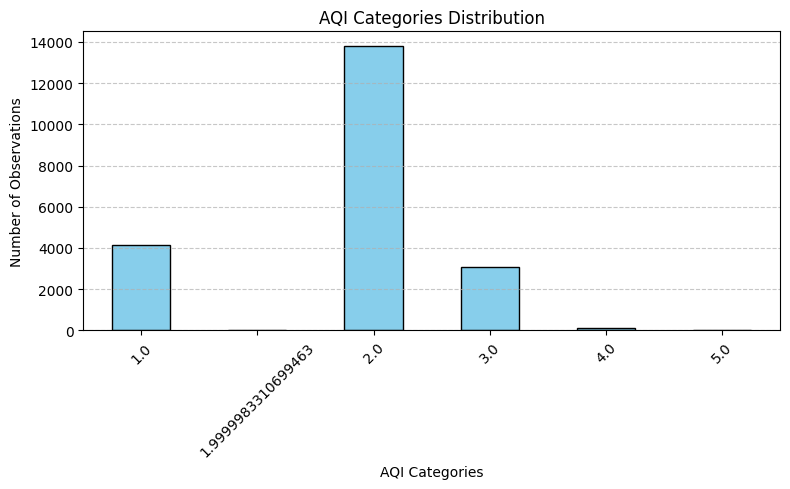

In [171]:
category_counts = df["AQI"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("AQI Categories Distribution")
plt.xlabel("AQI Categories")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [172]:
df["AQI"].value_counts()

AQI
2.000000    13815
1.000000     4125
3.000000     3099
4.000000      112
5.000000       16
1.999998        1
Name: count, dtype: int64

Since there should be only 1,2,3,4 and 5. We would have to investigate and find the weird value.

In [173]:
unique_rows = df[df["AQI"].duplicated(keep=False) == False]
unique_rows

,datetime_local,AQI,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,year,month,day,hour,weekday,AQI_lag_1,AQI_lag_2,AQI_lag_3,AQI_lag_24,AQI_lag_168
20552,2025-06-02 10:00:00+03:00,1.999998,98.57,0.09,0.41,78.43,0.21,0.0,0.0,1.31,2025,6,2,10,1,1.0,1.0,1.0,2.0,1.0


Since we found it, it is only fair to remove it since I only want strictly clean categorical AQI classes.

As in the future, it could cause issues in modeling or analysis that expect discrete AQI categories.

In [174]:
df = df.dropna() 
df = df[df["AQI"].isin([1, 2, 3, 4, 5])]

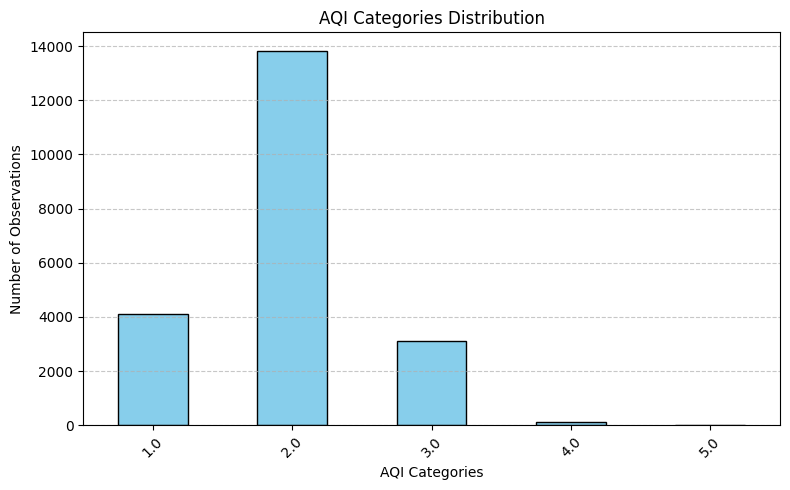

In [175]:
category_counts = df["AQI"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("AQI Categories Distribution")
plt.xlabel("AQI Categories")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

The data reveals that the vast majority of air quality readings in Varna fall into the lower AQI categories, indicating generally good air quality:

- **Category 2** has by far the highest number of observations, close to 14 000, suggesting that most of the time, Varna experiences air quality that is considered "Fair".
- **Category 1** follows, with over 4 000 observations, further confirming that clean air is common in the city.
- **Category 3** has about 3 000 observations, showing that occasional moderate pollution events do occur, but are less frequent.
- **Categories 4 and 5** are almost absent, indicating that unhealthy or hazardous air quality events are extremely rare in Varna.

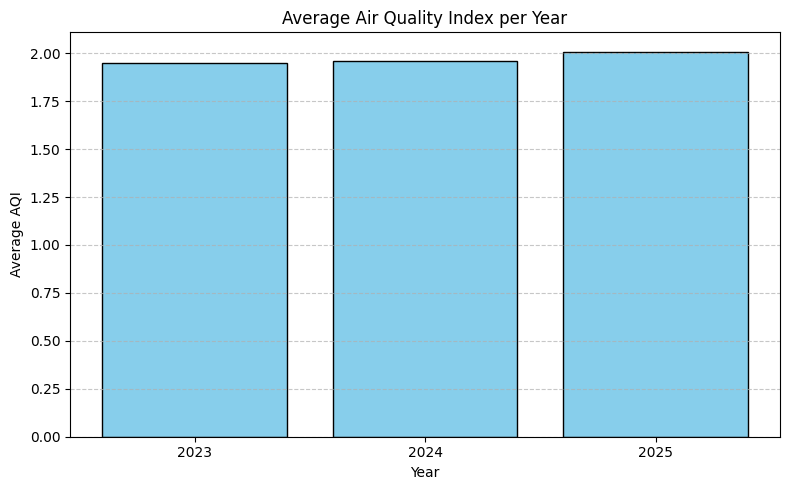

In [176]:
yearly_avg = df.groupby("year")["AQI"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(yearly_avg["year"], yearly_avg["AQI"], color="skyblue", edgecolor="black")
plt.title("Average Air Quality Index per Year")
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(yearly_avg["year"])
plt.tight_layout()
plt.show()

The data suggests a very mild upward trend in average AQI over the three years, especially in the last year - 2025, indicating a small deterioration in air quality, but the change is minimal and the overall average remains nearly constant.


To get a better look lets see the daily average AQI data through all 3 years.

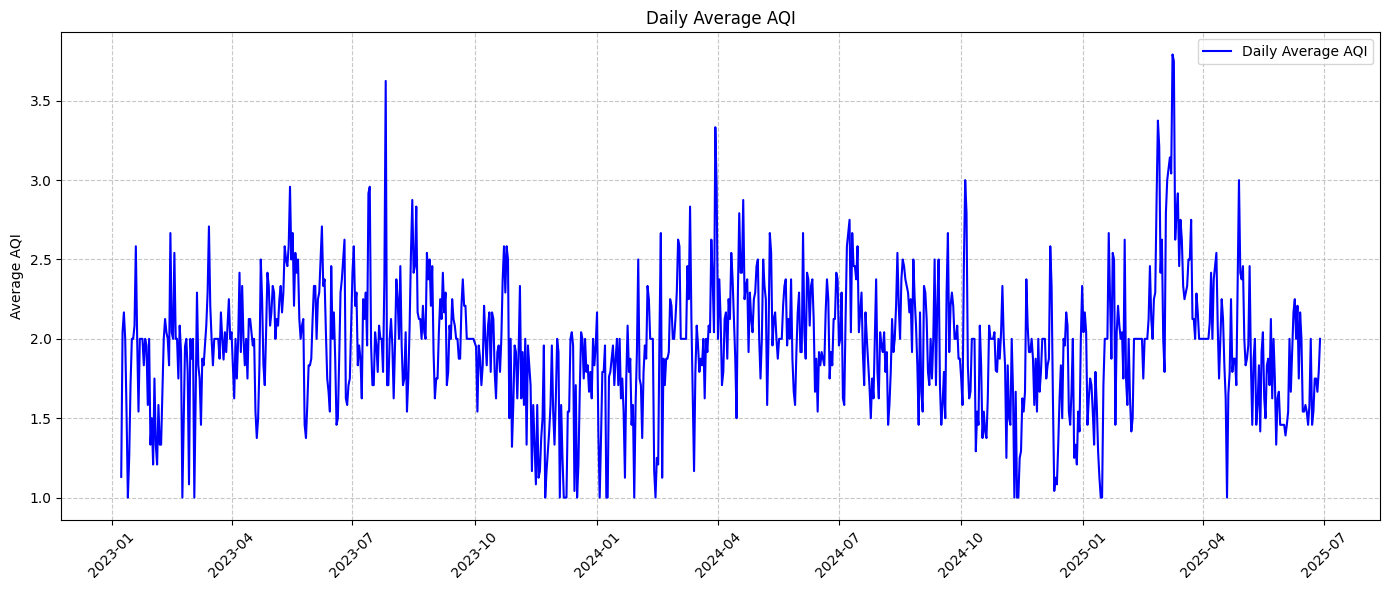

In [177]:
df["datetime_local"] = pandas.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-" + df["day"].astype(str).str.zfill(2)
)

daily_avg = df.groupby("datetime_local")["AQI"].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_avg["datetime_local"], daily_avg["AQI"], linestyle="-", color="b", label="Daily Average AQI")
plt.title("Daily Average AQI")
plt.ylabel("Average AQI")
plt.grid(visible=True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

The primary trend observed in the data is significant daily fluctuation in the AQI, without a clear, sustained long-term increase or decrease over the two-and-a-half-year period. Instead, a possible seasonal pattern emerges: there are noticeable peaks in AQI during summer months (such as July and August in both 2023 and 2024), as well as a very prominent high peak in early 2025 (around February-March). In contrast, periods like late 2023 and late 2024 (October-November) show relatively lower AQI values. Overall, the data suggests volatility and potential seasonality rather than a strong linear trend in air quality over time.

The prominent winter peak in early 2025 is likely due to increased use of solid fuels for domestic heating, which raises emissions of particulate matter. In summer, the peaks may be linked to higher tourism, increased vehicle traffic and more frequent outdoor activities, all of which boost emissions. Strong sunlight and higher temperatures can also promote the formation of secondary pollutants like ground-level ozone, worsening air quality during hotter months. Lower AQI values in late autumn likely reflect reduced heating needs, fewer extreme weather events and potentially lower tourist activity, allowing air quality to improve.

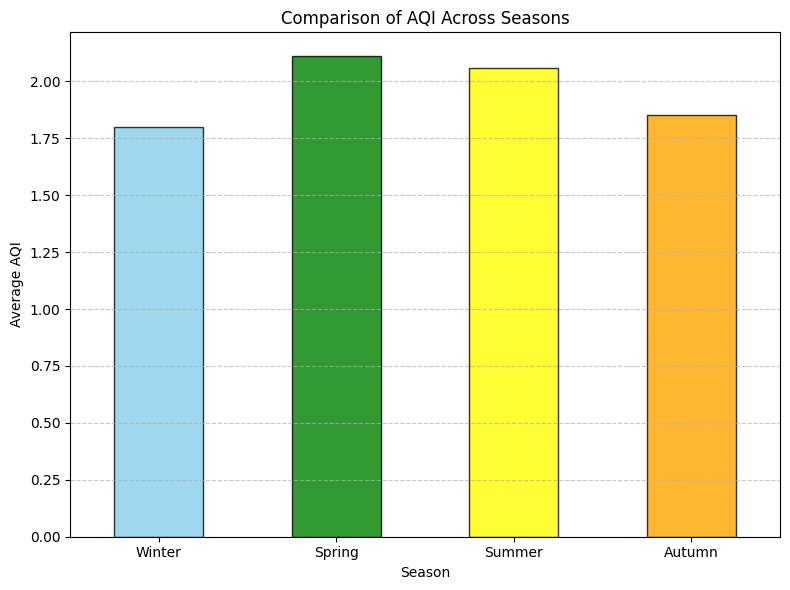

In [178]:
# determine the season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["season"] = df["month"].apply(get_season)

avg_aqi_season = df.groupby("season")["AQI"].mean().reindex(["Winter", "Spring", "Summer", "Autumn"])

plt.figure(figsize=(8, 6))
avg_aqi_season.plot(kind="bar", color=["skyblue", "green", "yellow", "orange"], alpha=0.8, edgecolor="black")
plt.title("Comparison of AQI Across Seasons")
plt.ylabel("Average AQI")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

As previously mentioned, let's analyse the AQI through out the seasons. 

At first glance, you can tell that air quality in Varna is generally worse during the warmer months (Spring and Summer) and better during the colder months (Autumn and Winter).

**Spring and Summer Peaks:**
- Pollen, dust and other particulates are more prevalent in spring and summer, which can elevate AQI readings.
- Warmer weather brings more outdoor activities, tourism and traffic, all of which can contribute to higher emissions.
- Higher temperatures and more sunlight can accelerate chemical reactions in the atmosphere, leading to the formation of ozone and other pollutants.

**Winter and Autumn Lows:**
- Coastal winds in Varna during autumn and winter may help disperse pollutants more effectively.
- Cooler temperatures and increased precipitation in these seasons can help clear the air of pollutants.
- There may be less traffic and fewer outdoor emissions sources during colder months.

However, there is a difference between both diagrams "Daily Average AQI" and "Comparison of AQI Across Seasons". The bar chart shows average AQI values, which can smooth out short-term spikes and dips. Daily data, on the other hand, highlights these fluctuations and can reveal short-term pollution events that are lost in seasonal averages. The apparent contradiction between the seasonal averages and daily patterns highlights the complexity of air quality dynamics in Varna.

Varna"s coastal location creates unique air quality dynamics that may not follow typical seasonal patterns. The city experiences specific meteorological conditions that can override general seasonal trends. Temperature inversions, which are common during colder months, trap pollutants close to the ground, but the timing and intensity of these inversions can vary significantly from year to year.

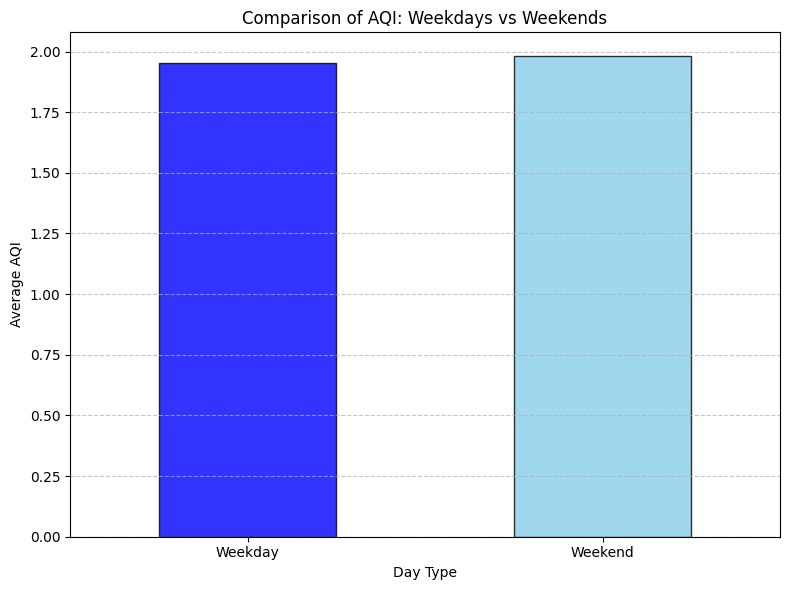

In [179]:
# determine if the day is a weekend/weekday
df["day_type"] = df["weekday"].apply(lambda x: "Weekend" if x >= 5 else "Weekday")

avg_aqi = df.groupby("day_type")["AQI"].mean()

plt.figure(figsize=(8, 6))
avg_aqi.plot(kind="bar", color=["blue", "skyblue"], alpha=0.8, edgecolor="black")

plt.title("Comparison of AQI: Weekdays vs Weekends")
plt.ylabel("Average AQI")
plt.xlabel("Day Type")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


The bar chart compares the average AQI in Varna between weekdays and weekends. The values are very close, but weekends show a slightly higher average AQI, indicating worse air quality. 

This small increase on weekends can be explained again by the active tourism and leisure culture. On weekends, both locals and tourists are more likely to engage in outdoor and recreational activities, leading to increased use of personal and public transport.

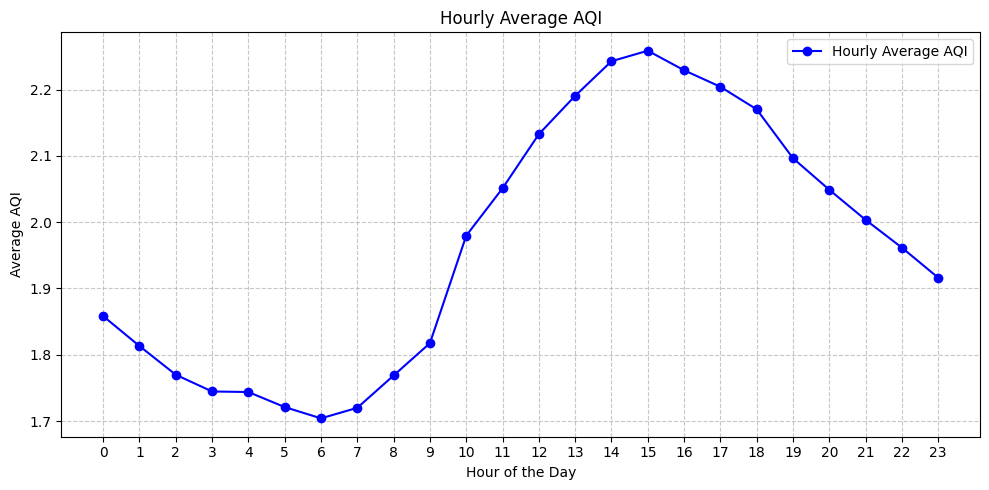

In [180]:
hourly_avg = df.groupby("hour")["AQI"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg["hour"], hourly_avg["AQI"], marker="o", linestyle="-", color="b", label="Hourly Average AQI")
plt.title("Hourly Average AQI")
plt.xlabel("Hour of the Day")
plt.ylabel("Average AQI")
plt.xticks(range(0, 24, 1))
plt.grid(visible=True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

Unlike the previous graphs, this one clearly shows a very distinct and strong daily trend. 

The AQI is at its lowest in the early morning hours (around 6 AM) almost at 1.7. It then shows a steady and significant increase throughout the day, reaching its peak in the afternoon (between 2 PM and 4 PM), with the highest value around 2.25. Following the peak, the AQI gradually decreases through the evening and night until midnight. This cyclical pattern indicates that air quality is generally best in the early morning and tends to be worse during the afternoon.

n the early morning, fewer vehicles are on the road and industrial activity is low, leading to reduced emissions and better air quality. As the day progresses, traffic increases due to commuting, business operations and tourism activities, all of which emit more pollutants. Additionally, warmer daytime temperatures and stronger sunlight can enhance the formation of secondary pollutants. As evening approaches, everyone slows down and when it comes to the temperature it lowers down, allowing the AQI to gradually improve through the night.

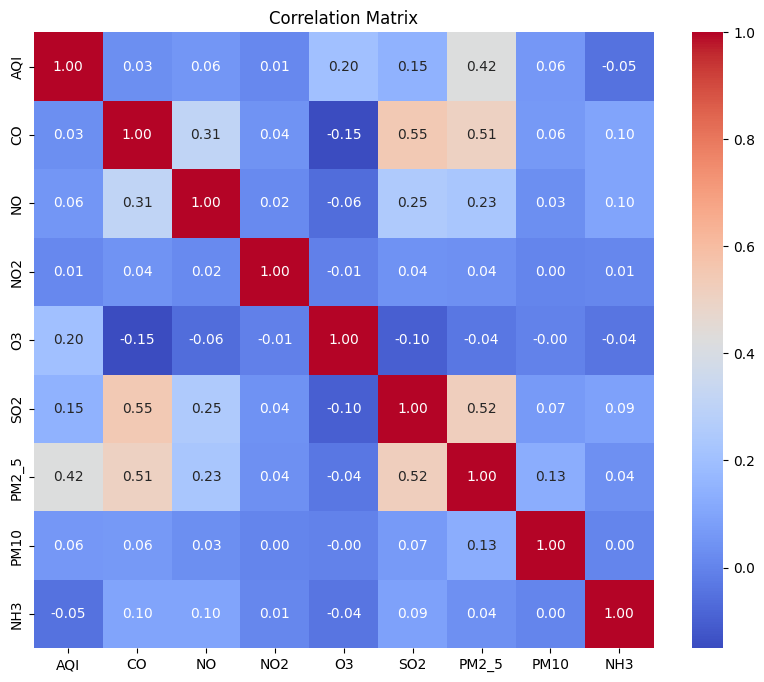

In [181]:
focus_columns = ["AQI", "CO", "NO", "NO2", "O3", "SO2", "PM2_5", "PM10", "NH3"]
corr_matrix_focus = df[focus_columns].corr()

plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_matrix_focus, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()


The correlation matrix reveals several interesting relationships among the air quality features. 

The strongest positive correlations are observed between carbon monoxide (CO) and sulfur dioxide (SO₂) at 0.55, as well as between CO and PM2.5 at 0.51, and SO₂ and PM2.5 at 0.52. These strong correlations suggest that these pollutants often originate from similar sources, such as vehicle emissions, industrial activities or the burning of fossil fuels. Their presence in the air tends to rise and fall together, which is typical in urban and industrial environments.

Particulate matter (PM2.5) also shows a moderate positive correlation with the AQI at 0.42, indicating that PM2.5 levels have a significant impact on the overall air quality as measured by the AQI. In contrast, other pollutants like nitrogen dioxide (NO₂), nitrogen monoxide (NO) and ammonia (NH₃) show very weak or almost no correlation with AQI, suggesting that they play a less direct role in determining the AQI values in Varna.

Ozone (O₃) behaves differently compared to the other pollutants. Its correlations with most other features are weak or even slightly negative, such as with CO (-0.15) and SO₂ (-0.10). This is expected, as ozone is a secondary pollutant formed through photochemical reactions in the atmosphere, rather than being directly emitted from common sources like vehicles or industry. Its formation and concentration are influenced by sunlight and other atmospheric conditions, which can differ from the factors affecting primary pollutants.

Ammonia (NH₃) stands out as largely independent from the other features, with correlations close to zero. This suggests that its sources and fluctuations are unrelated to those of the other measured pollutants, possibly reflecting agricultural activities or waste management practices that are less tied to urban air pollution sources.

In summary, the matrix shows that in Varna, pollutants like CO, SO₂ and PM2.5 are closely linked, likely due to shared sources, and PM2.5 is a major driver of AQI. Ozone and ammonia, on the other hand, are influenced by different factors and do not strongly correlate with the main urban pollutants. This pattern is typical for coastal or urban areas where both local emissions and atmospheric processes play important roles in shaping air quality.

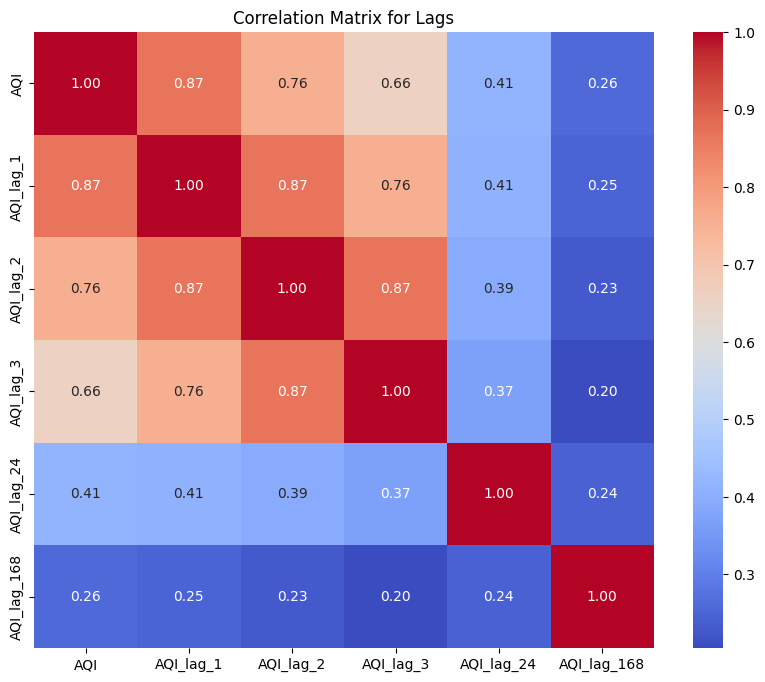

In [182]:
focus_columns = ["AQI", "AQI_lag_1", "AQI_lag_2", "AQI_lag_3", "AQI_lag_24", "AQI_lag_168"]
corr_matrix_focus = df[focus_columns].corr()

plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_matrix_focus, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for Lags")
plt.show()


The current AQI is most strongly correlated with its immediate past values, showing a correlation of 0.71 with AQI_lag_1, 0.62 with AQI_lag_2 and 0.53 with AQI_lag_3. This indicates a strong short-term temporal dependence, where recent AQI values are highly predictive of the current AQI. 

As the lag increases, the correlation decreases noticeably: AQI_lag_24 (representing a 24-hour lag) has a correlation of 0.36 with the current AQI and AQI_lag_168 (a one-week lag) drops further to 0.22. This trend is consistent across the matrix, with immediate lags being more strongly correlated with each other and with the current AQI, while more distant lags show weaker relationships. These findings suggest that while AQI exhibits strong short-term autocorrelation, the influence of past values diminishes over longer periods. 

For modeling purposes, it is important to consider that including many closely spaced lags may introduce redundancy due to high multicollinearity, while more distant lags contribute less predictive power. 

## Target variable 🎯
It is clear that the AQI is the target, while the features consist of the datetime variables, including the lagged ones - only the more recent ones, as the Correlation Matrix showed the highest correlation with them.

I experimented with three different versions, focusing solely on the datetime-based one, one including all lags and datetimes and one excluding the more distant lags. Overall, the final version appears to be the best, so I have decided to keep it.

In [183]:
y = df["AQI"]
X = df[["year", "month", "day", "hour", "weekday", "AQI_lag_1", "AQI_lag_2", "AQI_lag_3"]]

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 21167 observations, of which 16933 are now in the train set and 4234 in the test set.


## Modelling 🧬
I want to prioritize avoiding large errors, which is especially important for health alerts and policy decisions. To achieve this, I would focus on Mean Squared Error (MSE) since it penalizes large errors more severely than Mean Absolute Error (MAE). This approach is crucial in public health scenarios where a single significant error - such as failing to predict a dangerous spike in pollution - can have serious consequences.

Here’s an explanation of why each model I have used could be helpful for the AQI prediction:

**Linear Regression**
- Why helpful: Simple, interpretable and fast. It establishes a baseline for prediction and is useful when relationships between features and AQI are mostly linear.
- Limitations: May underperform if relationships are non-linear or interactions are complex.

**Random Forest**
- Why helpful: Handles non-linear relationships and feature interactions well. Robust to outliers and noise. Often achieves high accuracy and can indicate feature importance.
- Limitations: Less interpretable than linear models and can be slower on very large datasets.

**XGBoost**
- Why helpful: State-of-the-art gradient boosting. Highly accurate, handles missing values and provides feature importance. Good for complex, non-linear patterns.
- Limitations: More complex to tune and may overfit if not properly regularized.

**Gradient Boosting**
- Why helpful: Builds trees sequentially to correct errors of previous trees, often leading to high accuracy. Handles non-linear data well.
- Limitations: Sensitive to noisy data and may require careful tuning.

**Extra Trees**
- Why helpful: Similar to Random Forest, but uses random splits for faster training. Can be more robust to noise and overfitting.
- Limitations: May be less accurate on some datasets compared to Random Forest or XGBoost.

**Bagging**
- Why helpful: Reduces variance by averaging multiple models trained on different subsets of data. Improves stability and accuracy.
- Limitations: May not improve bias and is less effective if base models are already low-variance.

**SVR (Support Vector Regression)**
- Why helpful: Effective for non-linear relationships using kernel tricks. Robust to outliers and works well in high-dimensional spaces.
- Limitations: Can be slow on large datasets and requires careful parameter tuning.

**KNN (K-Nearest Neighbors)**
- Why helpful: Simple, non-parametric and can capture local patterns in data. Often performs well in practice for AQI prediction.
- Limitations: Sensitive to distance metrics and feature scaling. Computationally expensive for large datasets.

**Ridge**
- Why helpful: Regularized version of linear regression, reduces overfitting by penalizing large coefficients. Performs well when multicollinearity is present.
- Limitations: Still assumes linear relationships.

**Lasso**
- Why helpful: Like Ridge, but also performs feature selection by driving some coefficients to zero. Useful for interpretability and high-dimensional data.
- Limitations: May discard useful features if regularization is too strong.

**LGBM (LightGBM)**
- Why helpful: Highly efficient, handles large datasets quickly and often achieves top performance. Good for both regression and classification tasks.
- Limitations: Requires careful tuning to avoid overfitting.

**CatBoost**
- Why helpful: Handles categorical features natively, robust to overfitting and requires little data preprocessing. Often among the best-performing models for AQI prediction.
- Limitations: Slower than some other boosting algorithms on very large datasets.

In [185]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "Bagging": BaggingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "LGBM": LGBMRegressor(force_col_wise=True, verbose=-1),
    "CatBoost": CatBoostRegressor(verbose=0)
}

results= []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append((name, mae, mse, r2))

results = pandas.DataFrame(results, columns=["Model", "MAE", "MSE", "R²"])
results = results.sort_values("MSE")

results

,Model,MAE,MSE,R²
10,LGBM,0.152107,0.087584,0.769838
11,CatBoost,0.157644,0.087731,0.769454
3,Gradient Boosting,0.153346,0.088588,0.767200
2,XGBoost,0.154119,0.088841,0.766535
0,Linear Regression,0.140902,0.093917,0.753197
8,Ridge,0.140958,0.093918,0.753195
1,Random Forest,0.162990,0.094793,0.750894
5,Bagging,0.164100,0.099806,0.737720
4,Extra Trees,0.162744,0.100594,0.735650
7,KNN,0.195749,0.109495,0.712260


**Best Performing Models**  
LGBM and CatBoost are the top performers for Mean Squared Error (MSE) and R², achieving very similar scores. However, LGBM is slightly better across all three metrics. The MSE and R² values are almost identical, but LGBM edges out CatBoost. Gradient Boosting and XGBoost also demonstrate strong performance, with only slightly higher (worse) MSE and lower R² values.

**Lowest Mean Absolute Error (MAE)**  
Linear Regression and Ridge have the lowest MAE, making them the best for average error. However, their MSE and R² scores do not match those of the boosting models. This indicates that while they excel at minimizing small errors, they may overlook some significant spikes in Air Quality Index (AQI) readings. The performance of Ridge and Linear Regression is nearly identical, suggesting that regularization has little effect in this situation.

**Tree-Based Models**  
Random Forest, Extra Trees and Bagging models perform worse than the boosting models but still outperform KNN and SVR/Lasso. Among these tree-based models, Random Forest is the best, though it still lags behind the boosting methods. Bagging performs slightly worse than both Extra Trees and Random Forest.

**Poor Performers**  
KNN shows higher errors and lower R², though it still performs better than the worst models. SVR and Lasso exhibit very poor performance; specifically, SVR has significantly higher MAE and MSE, with an R² value that is nearly zero. Lasso performs even worse, with a negative R², indicating that the model is less effective than simply predicting the mean.

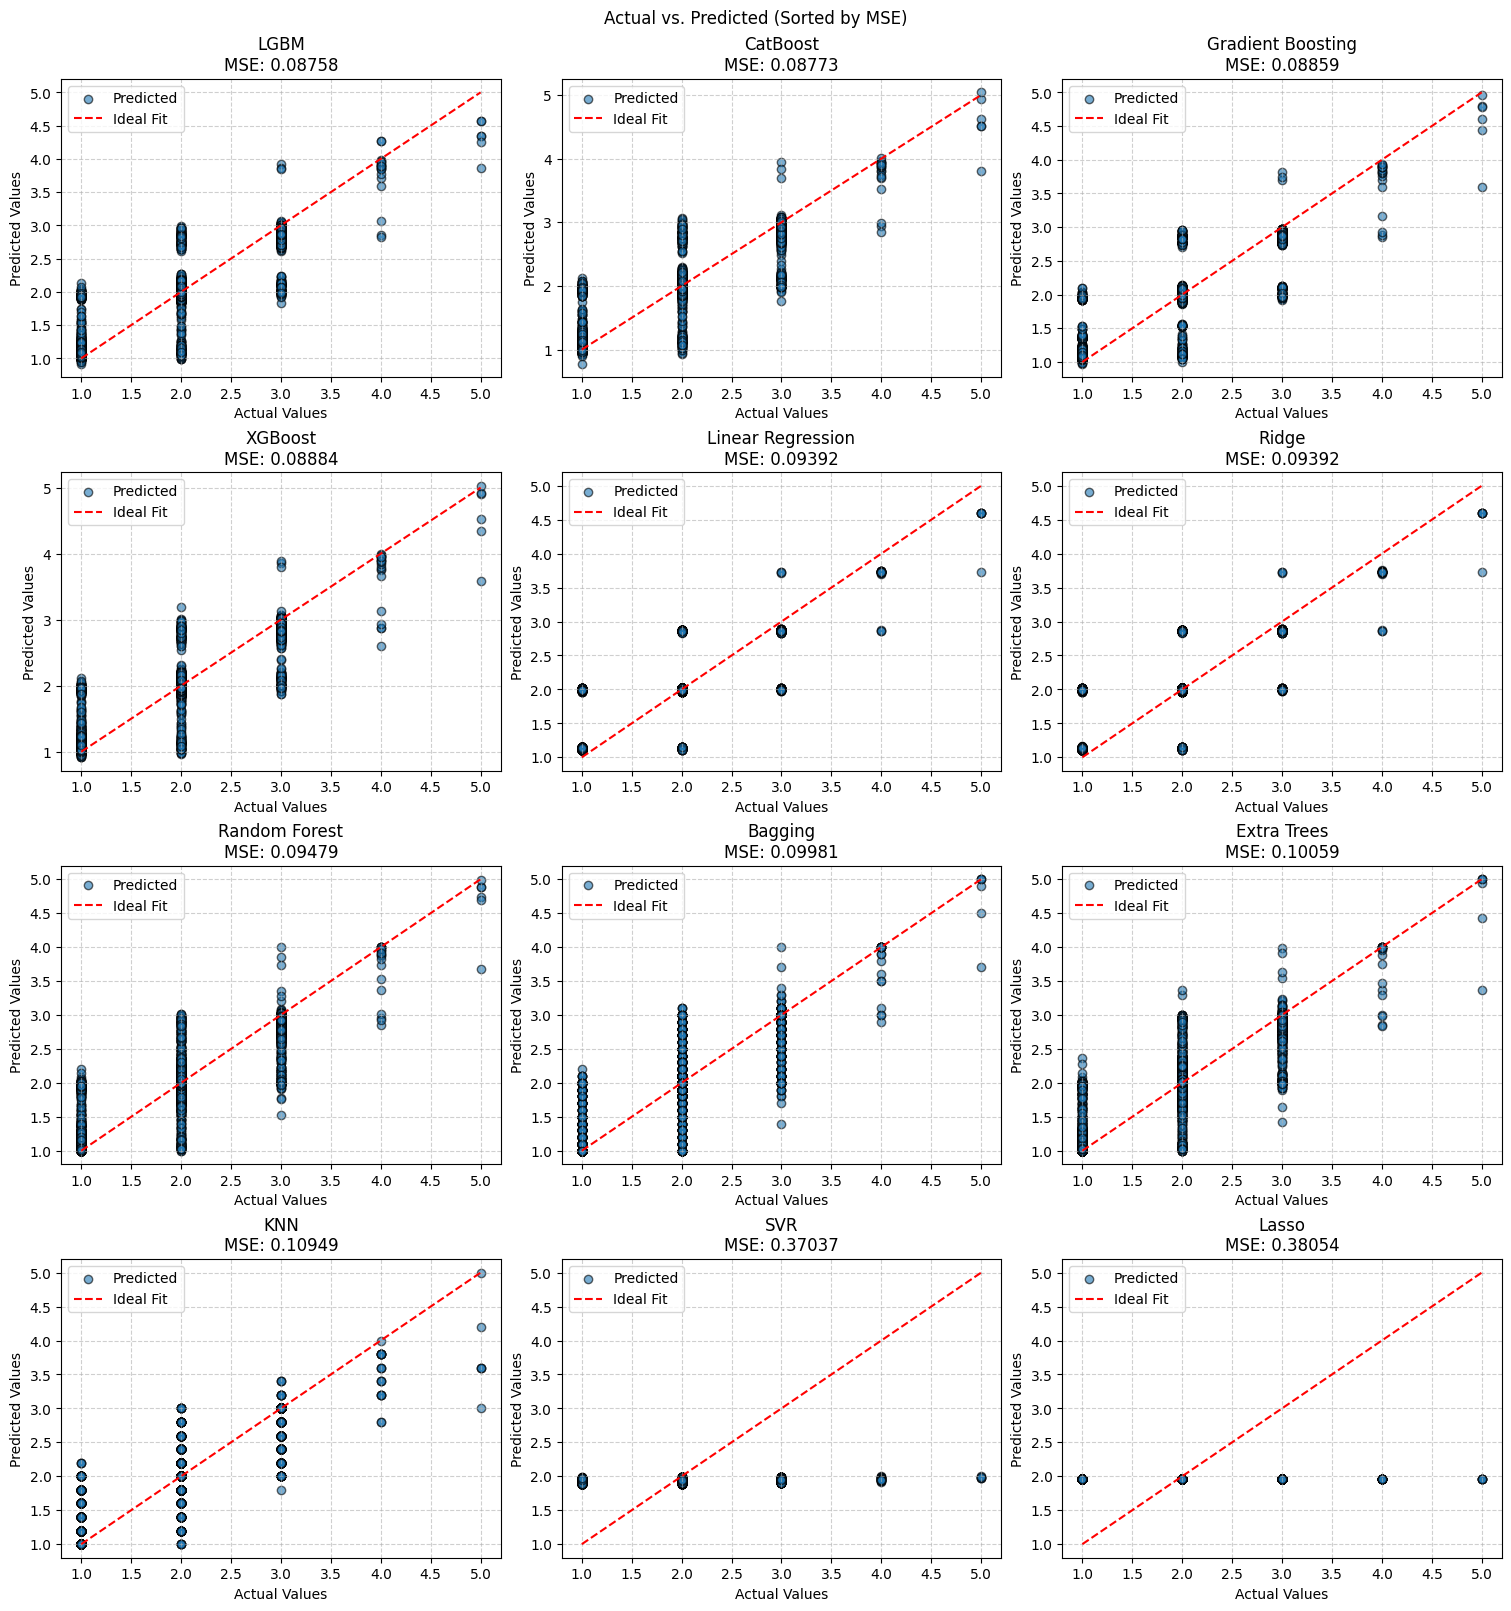

In [186]:
sorted_results = results.sort_values("MSE").reset_index(drop=True)

fig, axes = plt.subplots(4, 3, figsize=(15, 16), constrained_layout=True)
axes = axes.flatten()

for i, row in sorted_results.iterrows():
    name = row["Model"]
    mse = row["MSE"]
    model = models[name]
    preds = model.predict(X_test)

    ax = axes[i]
    ax.scatter(y_test, preds, alpha=0.6, edgecolor="k", label="Predicted")
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--", label="Ideal Fit")
    ax.set_title(f"{name}\nMSE: {mse:.5f}")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Actual vs. Predicted (Sorted by MSE)")
plt.show()

**Ensemble Tree Methods** (Random Forest, XGBoost, Gradient Boosting, Extra Trees, Bagging, LGBM, CatBoost):  
These models typically offer better predictions, with data points clustering closer to the ideal line and exhibiting less variance. They effectively manage the categorical and ordinal nature of the target variable.

**Linear Models** (Linear Regression, Ridge, Lasso):  
These models exhibit higher variance and systematic bias, particularly at the extremes of actual values. Lasso, in particular, underperforms, likely due to underfitting the data.

**SVR and KNN**:  
SVR struggles to capture the full range of actual values, resulting in sparse and inaccurate predictions. KNN demonstrates clustering, but with significant variance, indicating it is less effective in modeling the underlying data structure.

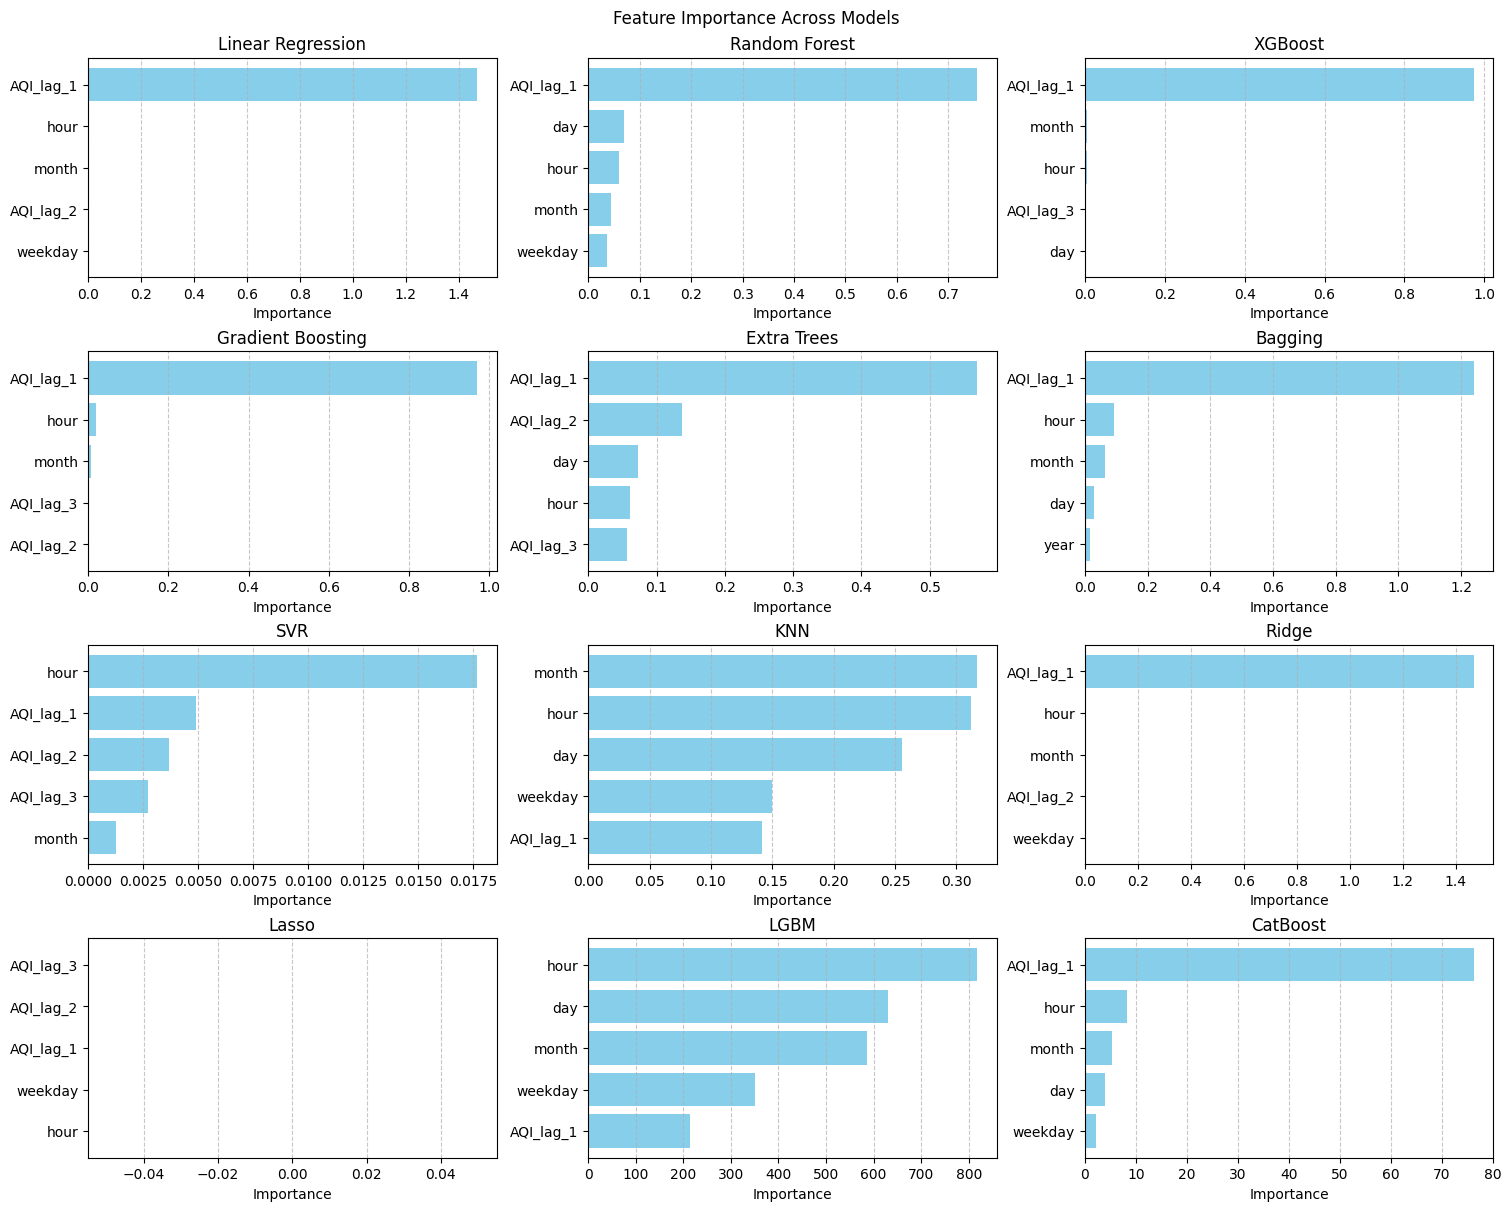

In [187]:
feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {i}" for i in range(X_train.shape[1])]

fig, axes = plt.subplots(4, 3, figsize=(15, 4 * 3), constrained_layout=True)
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if hasattr(model, "feature_importances_"):  # for tree-based models
        importances = model.feature_importances_
    else:  # for non-tree-based models
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean

    sorted_idx = numpy.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]

    ax = axes[idx]
    ax.barh(sorted_features[:5], sorted_importances[:5], color="skyblue")
    ax.set_title(f"{name}")
    ax.set_xlabel("Importance")
    ax.tick_params(axis="y")
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.7)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Importance Across Models")
plt.show()

**Dominance of AQI_lag_1:**  
In nearly all models - including Linear Regression, Random Forest, XGBoost, Gradient Boosting, Extra Trees, Bagging, Ridge and CatBoost - AQI_lag_1 is the most important feature by a significant margin. This indicates that the previous value of the AQI (Air Quality Index) is the strongest predictor of the current value, which is common in time series forecasting.

**Secondary Features:**  
Features such as hour, month and AQI_lag_2 or AQI_lag_3 occasionally demonstrate moderate importance, especially in models like K-Nearest Neighbors (KNN), Support Vector Regression (SVR) and LightGBM (LGBM). In models like LGBM and KNN, the distribution of feature importance is more balanced, with other features, such as hour, day, month and weekday, also contributing meaningfully. 

SVR, on the other hand, places the most weight on the hour feature, showing AQI_lag_1 and other lag features to be less dominant compared to other models.

**Sparse or Negative Importance:**  
The Lasso model seems to assign near-zero or even negative importance to all features, which may indicate over-regularization or that the model is unable to capture the relationships effectively. Some models, like Ridge and Linear Regression, focus heavily on AQI_lag_1, with other features contributing minimally.

**Tree-Based Models:**  
Models such as Random Forest, Extra Trees and Gradient Boosting consistently highlight AQI_lag_1 as the leading feature, with other features contributing very little. Bagging and CatBoost also follow this trend.

**Model Differences:**  
KNN and LGBM show a more balanced distribution of feature importance, suggesting that these models may be capturing more complex relationships or interactions among the features. Notably, SVR emphasizes the hour feature as the most important, reflecting its sensitivity to cyclical or daily patterns.

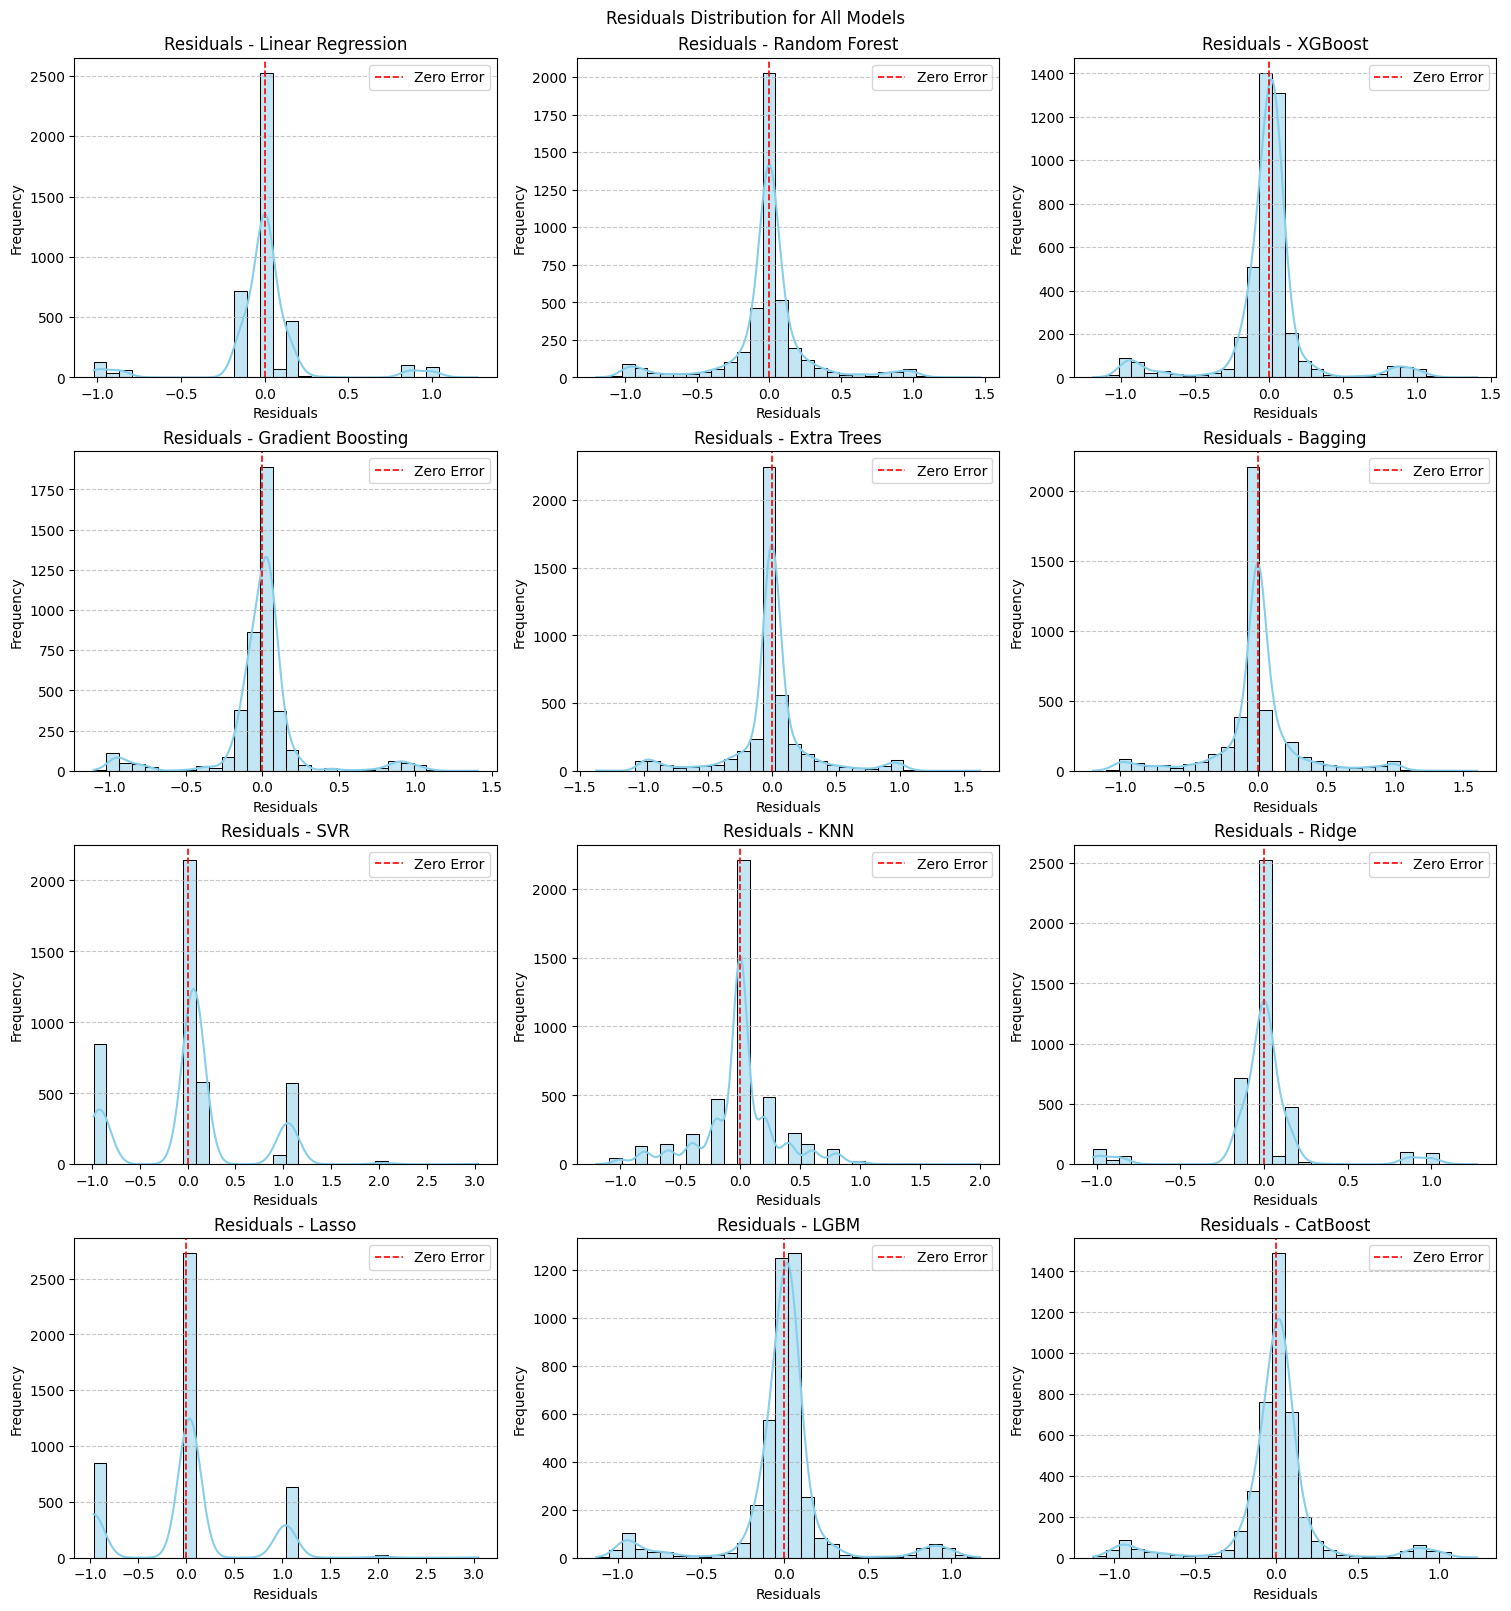

In [188]:
fig, axes = plt.subplots(4, 3, figsize=(15, 16), constrained_layout=True)
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    preds = model.predict(X_test)
    residuals = y_test - preds

    ax = axes[i]
    seaborn.histplot(residuals, kde=True, color="skyblue", bins=30, edgecolor="black", ax=ax)
    ax.set_title(f"Residuals - {name}")
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Frequency")
    ax.axvline(0, color="red", linestyle="--", linewidth=1.2, label="Zero Error")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Residuals Distribution for All Models")
plt.show()

**Central Tendency**  
Most models show residuals that are centered around zero, indicating unbiased predictions.

**Spread and Shape**  
- **Linear Regression, Ridge and Lasso:** The residuals are tightly concentrated around zero but exhibit some outliers, particularly in the case of Lasso and Support Vector Regression (SVR), which show clear spikes at the extremes.
- **Tree-Based Models (Random Forest, Extra Trees, XGBoost, Gradient Boosting, Bagging, LightGBM and CatBoost):** These models generally demonstrate narrow, tall distributions, with most residuals clustered closely around zero. This suggests high predictive accuracy and low variance.
- **SVR and Lasso:** Both models display bimodal or multi-peaked distributions, with a significant number of residuals at the extremes. This indicates that these models may be underfitting or not well-suited for the underlying data distribution.
- **K-Nearest Neighbors (KNN):** This model shows a wider spread of residuals compared to tree-based models, with more residuals further from zero, suggesting higher variance or less precise predictions.

**Outliers**  
- **SVR and Lasso:** These models exhibit pronounced outliers or extreme residual values, which could indicate poor model fit or sensitivity to specific data points.
- **Tree-Based Models:** These models have fewer extreme outliers, indicating more robust performance overall.

### Stacking 🥣
Stacking can improve performance by combining predictions from multiple models. For optimal stacking, we must select models that perform well and have diverse strengths. 

**Top Performing Models:** LGBM (LightGBM), CatBoost, Gradient Boosting and XGBoost

These models have the lowest Mean Absolute Error (MAE) and Mean Squared Error (MSE) while maintaining high R². They are all gradient-boosting algorithms, but since they use different implementations, their predictions may still provide complementary insights for stacking.

In [ ]:
base_learners = [
    ('lgbm', LGBMRegressor(random_state=42)),
    ('catboost', CatBoostRegressor(verbose=0, random_state=42)),
    ('xgboost', XGBRegressor(random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(random_state=42)),
]

meta_model = Ridge()
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stacking_model.fit(X_train, y_train)
stack_preds = stacking_model.predict(X_test)
stack_mae = mean_absolute_error(y_test, stack_preds)
stack_mse = mean_squared_error(y_test, stack_preds)
stack_r2 = r2_score(y_test, stack_preds)

print(f"MAE: {stack_mae:.6f}, MSE: {stack_mse:.6f}, R²: {stack_r2:.6f}")

Stacking Model Performance:
MAE: 0.152160, MSE: 0.087252, R²: 0.770710


In [ ]:
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

cv_results = cross_validate(
    stacking_model, X, y, cv=5, scoring=scoring, return_train_score=True, n_jobs=-1
)

print("Cross-Validation Results:")
print(f"Mean MAE: {-cv_results['test_MAE'].mean():.6f} ± {cv_results['test_MAE'].std():.6f}")
print(f"Mean MSE: {-cv_results['test_MSE'].mean():.6f} ± {cv_results['test_MSE'].std():.6f}")
print(f"Mean R²: {cv_results['test_R2'].mean():.6f} ± {cv_results['test_R2'].std():.6f}")

Cross-Validation Results:
Mean MAE: 0.150618 ± 0.003798
Mean MSE: 0.085138 ± 0.003405
Mean R²: 0.765916 ± 0.019470


The stacking model is definitely robust. The mean absolute error (MAE) and mean squared error (MSE) are slightly lower during cross-validation compared to the test set, which is normal and indicates good generalization. The R² value also remains stable across folds with a small standard deviation.

Stacking did not outperform LightGBM (LGBM) by a significant margin. This is common when all the base models (such as LGBM, CatBoost, XGBoost, etc.) are already strong and similar in performance. Stacking is most advantageous when the base models have differing strengths and weaknesses. 

If you prioritize simplicity and speed, LGBM is an excellent choice. However, if you are aiming for the best possible performance - even if the improvement is only slight - stacking is a reliable option and that is my preference.

### Boosting 🚀

In [270]:
adaboost_model = AdaBoostRegressor(
    CatBoostRegressor(verbose=0, random_state=42)
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model.fit(X_train, y_train)
adaboost_preds = adaboost_model.predict(X_test)
adaboost_mae = mean_absolute_error(y_test, adaboost_preds)
adaboost_mse = mean_squared_error(y_test, adaboost_preds)
adaboost_r2 = r2_score(y_test, adaboost_preds)

print(f"MAE: {adaboost_mae:.6f}, MSE: {adaboost_mse:.6f}, R²: {adaboost_r2:.6f}")

MAE: 2.231527, MSE: 17.230662, R²: 0.991186


In [268]:
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

cv_results = cross_validate(adaboost_model, X, y, cv=5, scoring=scoring, return_train_score=True, n_jobs=-1)

print("Cross-Validation Results:")
print(f"Mean MAE: {-cv_results['test_MAE'].mean():.6f} ± {cv_results['test_MAE'].std():.6f}")
print(f"Mean MSE: {-cv_results['test_MSE'].mean():.6f} ± {cv_results['test_MSE'].std():.6f}")
print(f"Mean R²: {cv_results['test_R2'].mean():.6f} ± {cv_results['test_R2'].std():.6f}")

Cross-Validation Results:
Mean MAE: 22.708829 ± 6.574601
Mean MSE: 830.236160 ± 484.220949
Mean R²: 0.472152 ± 0.175643


The AdaBoost model with CatBoost as the base estimator showed a surprisingly high R² value (0.991), indicating strong fit on the training data. However, it exhibited very poor generalization during cross-validation, with a drastically increased mean MAE (22.7) and MSE (830.2) and a much lower mean R² (0.47). This discrepancy suggests the model is likely overfitting the training data and performing inconsistently on unseen data, making it unsuitable for reliable AQI prediction in this context.

## Final Conclusions 📝
### Domain Analysis
VarnaAir focuses on predicting the Air Quality Index (AQI) for Varna, Bulgaria, leveraging reliable, continuous data from a recently accessed API providing comprehensive environmental metrics from 2023 onwards. The project aims to support local residents, policymakers and environmental authorities by delivering timely and accurate air quality forecasts to inform health advisories and urban planning decisions.

A key part of the project involved analyzing and understanding various chemical pollutants measured in the data and how their concentrations impact air quality and human health. This domain knowledge was essential to interpret the data correctly and build more meaningful predictive models.

### Data Analysis (DAIA)
The project initially aimed to leverage multiple data sources, including local sensor data, for predicting the Air Quality Index (AQI) in Varna, Bulgaria. However, challenges arose due to incomplete datasets and restrictions on API calls. Specifically, the first API used a /recent endpoint, which provided data primarily from 2023. While this was somewhat recent, it lacked data from 2025, necessitating additional efforts to fill gaps with CSV files. This included downloading monthly data for two different air stations, an approach initially designed to improve accuracy by capturing a broader dataset. Unfortunately, this strategy proved impractical as the stations did not measure all necessary pollutants consistently, resulting in significant missing data.

To address these limitations, the dataset was rebuilt using a second API that offered consistent and gap-free historical data, including pollutant concentrations and AQI directly. Importantly, this API allowed date customization, enabling access to comprehensive data from 2025. This eliminated the need for manual data integration and ensured a robust and complete dataset.

Preprocessing the improved dataset involved minimal cleaning and normalization, as there were no missing values. Exploratory analysis revealed strong daily and seasonal air quality patterns, supporting more accurate modeling. Additionally, lagging was explored as a technique to improve predictions by incorporating past AQI values as features. During exploratory data analysis, lagging revealed a notable correlation between past and present AQI values, particularly over short time. However, the strength of this relationship diminished for longer lags, suggesting that while recent data is highly predictive, historical data from distant past periods holds less relevance. This approach leveraged temporal dependencies, capturing trends and short-term persistence in air quality changes to enhance the model's performance.

### Machine Learning
Multiple regression models were evaluated to predict the Air Quality Index (AQI) for Varna, using Mean Absolute Error (MAE), Mean Squared Error (MSE) and R² as performance metrics. Among the individual models, LightGBM demonstrated the best overall balance, achieving an MAE of 0.1521, MSE of 0.0876 and R² of 0.7698, with CatBoost, Gradient Boosting and XGBoost delivering comparable results. Linear models such as Ridge and Linear Regression showed slightly lower R² scores (~0.75) but remained competitive in terms of MAE.

A stacking ensemble combining the base learners (LGBM, CatBoost, XGBoost, Gradient Boosting) with a Ridge regression meta-model yielded further improvements, with an MAE of 0.1522, MSE of 0.0873 and R² of 0.7707. This indicates that blending multiple gradient boosting models captures complementary aspects of the data, enhancing predictive accuracy.

Conversely, AdaBoost using CatBoost base estimator underperformed, likely due to overfitting.

Although the models show strong overall predictive capability, occasional errors arise, especially during sudden pollution spikes. Incorporating fresh data continuously and exploring advanced time series or deep learning approaches may improve forecast robustness and accuracy over time.

If this project is continued in the future, I plan to build upon the stacking ensemble approach as it has demonstrated the most consistent and accurate performance so far.

### Conclusion
This project successfully demonstrated the feasibility of predicting Varna’s Air Quality Index (AQI) using machine learning techniques applied to reliable environmental data. Through careful domain understanding and thorough data preprocessing, several regression models were evaluated, with gradient boosting methods, particularly LightGBM and a stacking ensemble, showing the best predictive performance.

While some models struggled with overfitting or failed to generalize well, the stacking approach combining multiple strong learners consistently captured the complex patterns in the data. However, sudden pollution spikes remain challenging to predict accurately, highlighting opportunities for future improvements.

Overall, this work lays a solid foundation for building an effective air quality forecasting system to support public health and environmental decision-making in Varna.

### Future Recommendations 💡
#### Short-Term Possibilities
- **Expand Data Sources** 

Incorporate additional environmental and meteorological data, such as wind speed, humidity, temperature and traffic patterns. This can be achieved by integrating APIs from reliable services or local transportation authorities. These features will enhance the model’s ability to account for external factors that directly influence air quality, improving prediction accuracy and reliability.

- **Real-Time Data Integration** 

Implement pipelines to fetch, preprocess and integrate real-time data from environmental monitoring stations or APIs. Real-time integration ensures predictions are always based on the most recent conditions, enabling timely health advisories and more responsive environmental policies.

- **Model Interpretability** 

Use tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to explain predictions. For example, determining the relative influence of PM2.5 levels versus temperature on AQI predictions can inform policymakers about key drivers of pollution. Improved interpretability builds trust in the system and enables better-informed decision-making.

SHAP values quantify the contribution of each feature to a specific prediction. For instance, if PM2.5 is a major pollutant driving poor air quality, SHAP can illustrate its influence on individual AQI predictions across different days. It also provides global feature importance to understand trends across all predictions.

LIME works by approximating the complex model with a simpler interpretable model for a specific prediction. It helps users understand why the model made a particular decision by providing a straightforward explanation in terms of the most significant features for that prediction.

Clear model explanations foster better collaboration with local authorities and environmental experts, as they can align predictions with ground realities and local insights.

- **User-Centric Application**

Develop a user-friendly platform, such as a web dashboard or a mobile app, to present AQI forecasts. Including features like visual graphs, personalized health recommendations and alerts can make the system more accessible to residents. This will raise community awareness and help users plan activities based on predicted air quality.

#### Long-Term Possibilities
- **Advanced Time Series Modeling** 

Explore sophisticated techniques like LSTM (Long Short-Term Memory) networks or Prophet for capturing temporal dependencies and sudden fluctuations in air quality. These models can be trained using historical AQI and weather data to forecast future conditions with greater accuracy. Long-term, these methods could improve predictions during periods of rapid weather or pollution changes, such as seasonal transitions or industrial events.

- **Anomaly Detection and Handling** 

Implement algorithms to identify and manage outliers, such as pollution spikes caused by rare events (e.g., wildfires, industrial accidents). For example, integrating unsupervised techniques like Isolation Forests or clustering methods can flag anomalies. Addressing these anomalies ensures more reliable predictions and improves public trust in the system.

- **Continuous Model Updating** 

Establish a system for periodic model retraining as new data becomes available. This can involve setting up automated pipelines for data ingestion and training using cloud platforms. Continuous updates allow the model to adapt to evolving environmental patterns, ensuring sustained accuracy over time.

- **Collaboration with Local Authorities** 

Partner with municipal agencies and environmental organizations to validate predictions and align them with local policy needs. Collaborations could also involve sharing insights to optimize urban planning, such as implementing traffic restrictions on high-pollution days. Such partnerships increase the system’s impact and credibility while fostering a collaborative approach to environmental management.

### Ethical Considerations ⚖️
#### Data Representativeness and Bias

The dataset used for model training may not fully capture the diverse environmental, socio-economic and seasonal variations that affect air quality in Varna. For example, certain areas with higher industrial activity or less vegetation might be underrepresented in the data, leading to biased predictions that overlook localized pollution hotspots. Communities with limited access to green spaces or those located near industrial zones could be at a higher risk if the model fails to accurately represent their conditions. Biases in predictions may result in insufficient or delayed interventions in these areas. To mitigate these issues, it is essential to regularly update and expand the dataset to include diverse data points. Collaborating with local stakeholders and environmental groups can help ensure the data reflects real-world conditions.

#### Transparency of Model Limitations

Machine learning models inherently involve assumptions and uncertainties. Over-reliance on these predictions, without understanding their limitations, could lead to misinformed decisions. For instance, extreme pollution events might be underestimated due to a lack of historical examples in the training data. Stakeholders, including policymakers and the general public, should be clearly informed about the probabilistic nature of predictions. Highlighting confidence intervals and scenarios where the model might struggle (e.g., sudden weather changes) promotes informed decision-making. To address these concerns, it is crucial to include disclaimers regarding prediction reliability and provide confidence scores for each forecast. Utilizing model explanation tools can clarify why certain predictions were made and educate users about the potential limitations of data-driven insights.

#### Health and Safety Implications

Predictions related to the Air Quality Index (AQI) play a critical role in issuing health advisories, such as recommendations to avoid outdoor activities during high pollution levels. Inaccurate forecasts can have serious consequences - overestimation may cause unnecessary panic, while underestimation can expose individuals to harmful pollution. To mitigate these risks, models should be rigorously validated using hold-out test sets and real world scenarios before deployment. Establishing thresholds for issuing health advisories is vital to prioritize public safety by erring on the side of caution. Incorporating a review system where human experts assess critical predictions before they are widely disseminated would further enhance reliability.

#### Data Privacy and Usage

Integrating additional data sources, such as traffic patterns or weather APIs, introduces the risk of mishandling sensitive or personal information. For instance, detailed traffic data might inadvertently contain identifiable information. To mitigate these issues, it is necessary to adhere to strict data privacy standards, such as GDPR or other relevant regulations. Using anonymized and aggregated data whenever possible is recommended, along with avoiding the storage or processing of sensitive information that is not necessary. Ensuring that third-party APIs comply with the same ethical and privacy standards required for the project is also crucial.

#### Human Oversight and Accountability

Fully automating AQI predictions could lead to a lack of accountability if errors occur. While machine learning models can provide valuable insights, they should not replace the judgment and expertise of human analysts. Human experts can supply context that models might miss, such as unexpected local events affecting air quality (e.g., a chemical spill). They can also validate predictions to ensure reliability before dissemination. To enhance accountability, the system should be designed to augment, rather than replace, human expertise. Clear accountability frameworks must be established to define who is responsible for interpreting and acting on predictions. Regular training for staff is essential to ensure effective use of the system and comprehension of its outputs.

### Resourches
- **ChatGPT (2025).** - used for brainstorming, drafting and refining project content. https://chatgpt.com/
- **Grammarly.  (n.d.).** - used for grammatical accuracy and clarity improvement tool. https://grammarly.com
- **OpenWeatherMap. (n.d.).** - used for air pollution API. https://openweathermap.org/api/air-pollution
- **U.S. Environmental Protection Agency. (n.d.).** - used for  AQI breakpoints. https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html
- **World Health Organization. (n.d.).** https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health
- **AirNow. (n.d.). AQI basics.** http://airnow.gov/aqi/aqi-basics/#:~:text=Five%20major%20pollutants,nitrogen%20dioxide
- **Wikipedia. (n.d.).** https://en.wikipedia.org/wiki/Air_quality_index
- **Breeze Technologies. (n.d.).** https://www.breeze-technologies.de/blog/major-air-pollutants-their-impact-and-sources/


# Previous Approach 🔙
Initially, I approached the project using OpenAQ [https://openaq.org/]. However, I found a better API source, so I am discarding this part of the project but keeping it as proof of my work. 

The reason for my decision is that there was too much missing data. Additionally, since the AQI was absent and needed to be calculated, this model relied too heavily on calculations.

## Data provisioning 📦

Next, we will use an API key provided by OpenAQ [https://openaq.org/] to check the what Air Monitoring Stations are available in Varna, Bulgaria.

In [191]:
url = "https://api.openaq.org/v3/locations"
headers = {
    "X-API-Key": "c1061fd64a9bd88562b4bb823b7900ccdfd263a9a7aa54614de834dac611a4ca"
}
params = {
    "coordinates": "43.224389,27.915733",  # center of Varna
    "radius": 5000                         # 5 km radius
}

response = requests.get(url, headers=headers, params=params)

data = response.json().get("results", [])
df_nearby_stations = pandas.DataFrame(data)

print(df_nearby_stations[["id", "name", "locality"]])

        id                         name              locality
0     8843  AMS SOU Angel Kanchev-Varna                 Варна
1  2162113           AMS Chaika - Varna  National air network


Now that the IDs of each location are displayed, I can access each station's sensors to obtain the measurements.

### Angel Kanchev-Varna (part 1)

In [192]:
url = "https://api.openaq.org/v3/locations/8843/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest1 = pandas.DataFrame(results)

df_latest1

,id,name,parameter,datetimeFirst,datetimeLast,coverage,latest,summary
0,25777,o3 µg/m³,"{'id': 3, 'name': 'o3', 'units': 'µg/m³', 'dis...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
1,25778,no2 µg/m³,"{'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
2,25776,pm10 µg/m³,"{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
3,25779,co µg/m³,"{'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1000.0, 'q02': None, 'q25': None, 'me..."
4,25774,so2 µg/m³,"{'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
5,25775,pm25 µg/m³,"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
6,4272879,no µg/m³,"{'id': 19843, 'name': 'no', 'units': 'µg/m³', ...","{'utc': '2023-03-29T18:00:00Z', 'local': '2023...","{'utc': '2024-03-11T11:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-03-11T11:00:00Z', '...","{'min': 0.14, 'q02': None, 'q25': None, 'media..."


In [193]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Angel Kanchev
sensor_ids = [25777, 25778, 25776, 25779, 25774, 25775, 4272879]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df1 = pandas.DataFrame(results)

        df1 = df1.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df1["period"].apply(lambda x: x["datetimeFrom"]["utc"] if x else None),
            datetime_from_local=df1["period"].apply(lambda x: x["datetimeFrom"]["local"] if x else None),
            datetime_to_utc=df1["period"].apply(lambda x: x["datetimeTo"]["utc"] if x else None),
            datetime_to_local=df1["period"].apply(lambda x: x["datetimeTo"]["local"] if x else None),
            parameter_name=df1["parameter"].apply(lambda x: x.get("name") if isinstance(x, dict) else None),
            parameter_units=df1["parameter"].apply(lambda x: x.get("units") if isinstance(x, dict) else None)
        ).drop(columns=["flagInfo", "parameter", "period", "summary", "coverage", "coordinates"])

        sensor_data_frames.append(df1)

df1 = pandas.concat(sensor_data_frames, ignore_index=True)
df1

,value,sensor_id,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,parameter_name,parameter_units
0,56.93,25777,2020-04-20T17:00:00Z,2020-04-20T20:00:00+03:00,2020-04-20T18:00:00Z,2020-04-20T21:00:00+03:00,o3,µg/m³
1,25.44,25777,2020-04-20T18:00:00Z,2020-04-20T21:00:00+03:00,2020-04-20T19:00:00Z,2020-04-20T22:00:00+03:00,o3,µg/m³
2,23.04,25777,2020-04-20T19:00:00Z,2020-04-20T22:00:00+03:00,2020-04-20T20:00:00Z,2020-04-20T23:00:00+03:00,o3,µg/m³
3,30.51,25777,2020-04-20T20:00:00Z,2020-04-20T23:00:00+03:00,2020-04-20T21:00:00Z,2020-04-21T00:00:00+03:00,o3,µg/m³
4,25.95,25777,2020-04-20T21:00:00Z,2020-04-21T00:00:00+03:00,2020-04-20T22:00:00Z,2020-04-21T01:00:00+03:00,o3,µg/m³
...,...,...,...,...,...,...,...,...
695,14.49,4272879,2023-04-02T16:00:00Z,2023-04-02T19:00:00+03:00,2023-04-02T17:00:00Z,2023-04-02T20:00:00+03:00,no,µg/m³
696,1.68,4272879,2023-04-02T17:00:00Z,2023-04-02T20:00:00+03:00,2023-04-02T18:00:00Z,2023-04-02T21:00:00+03:00,no,µg/m³
697,1.76,4272879,2023-04-02T18:00:00Z,2023-04-02T21:00:00+03:00,2023-04-02T19:00:00Z,2023-04-02T22:00:00+03:00,no,µg/m³
698,2.85,4272879,2023-04-02T19:00:00Z,2023-04-02T22:00:00+03:00,2023-04-02T20:00:00Z,2023-04-02T23:00:00+03:00,no,µg/m³


### AMS Chaika - Varna (part 1)
Let's do the same for this station as well.

In [194]:
url = "https://api.openaq.org/v3/locations/2162113/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest2 = pandas.DataFrame(results)

df_latest2

,id,name,parameter,datetimeFirst,datetimeLast,coverage,latest,summary
0,7774820,no µg/m³,"{'id': 19843, 'name': 'no', 'units': 'µg/m³', ...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2024-03-11T11:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-03-11T11:00:00Z', '...","{'min': 1.36, 'q02': None, 'q25': None, 'media..."
1,7774916,so2 µg/m³,"{'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
2,7775044,co µg/m³,"{'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1000.0, 'q02': None, 'q25': None, 'me..."
3,7775045,no2 µg/m³,"{'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-29T02:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-29T02:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
4,8613114,pm10 µg/m³,"{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...","{'utc': '2024-03-18T07:00:00Z', 'local': '2024...","{'utc': '2024-06-06T06:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-06-06T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."


In [195]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Chaika
sensor_ids = [7774820, 7774916, 7775044, 7775045, 8613114]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df2 = pandas.DataFrame(results)

        df2 = df2.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df2["period"].apply(lambda x: x["datetimeFrom"]["utc"] if x else None),
            datetime_from_local=df2["period"].apply(lambda x: x["datetimeFrom"]["local"] if x else None),
            datetime_to_utc=df2["period"].apply(lambda x: x["datetimeTo"]["utc"] if x else None),
            datetime_to_local=df2["period"].apply(lambda x: x["datetimeTo"]["local"] if x else None),
            parameter_name=df2["parameter"].apply(lambda x: x.get("name") if isinstance(x, dict) else None),
            parameter_units=df2["parameter"].apply(lambda x: x.get("units") if isinstance(x, dict) else None)
        ).drop(columns=["flagInfo", "parameter", "period", "summary", "coverage", "coordinates"])

        sensor_data_frames.append(df2)

df2 = pandas.concat(sensor_data_frames, ignore_index=True)
df2

,value,sensor_id,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,parameter_name,parameter_units
0,1.51,7774820,2024-01-28T22:00:00Z,2024-01-29T00:00:00+02:00,2024-01-28T23:00:00Z,2024-01-29T01:00:00+02:00,no,µg/m³
1,1.65,7774820,2024-01-28T23:00:00Z,2024-01-29T01:00:00+02:00,2024-01-29T00:00:00Z,2024-01-29T02:00:00+02:00,no,µg/m³
2,1.54,7774820,2024-01-29T00:00:00Z,2024-01-29T02:00:00+02:00,2024-01-29T01:00:00Z,2024-01-29T03:00:00+02:00,no,µg/m³
3,1.62,7774820,2024-01-29T01:00:00Z,2024-01-29T03:00:00+02:00,2024-01-29T02:00:00Z,2024-01-29T04:00:00+02:00,no,µg/m³
4,1.66,7774820,2024-01-29T02:00:00Z,2024-01-29T04:00:00+02:00,2024-01-29T03:00:00Z,2024-01-29T05:00:00+02:00,no,µg/m³
...,...,...,...,...,...,...,...,...
495,-1.00,8613114,2024-03-29T19:00:00Z,2024-03-29T21:00:00+02:00,2024-03-29T20:00:00Z,2024-03-29T22:00:00+02:00,pm10,µg/m³
496,-1.00,8613114,2024-03-29T20:00:00Z,2024-03-29T22:00:00+02:00,2024-03-29T21:00:00Z,2024-03-29T23:00:00+02:00,pm10,µg/m³
497,-1.00,8613114,2024-03-29T21:00:00Z,2024-03-29T23:00:00+02:00,2024-03-29T22:00:00Z,2024-03-30T00:00:00+02:00,pm10,µg/m³
498,-1.00,8613114,2024-03-29T22:00:00Z,2024-03-30T00:00:00+02:00,2024-03-29T23:00:00Z,2024-03-30T01:00:00+02:00,pm10,µg/m³


The next step is to combine both datasets, as we have the latest measurements from both stations.

In [196]:
combined_df = pandas.concat([df1, df2], ignore_index=True)

print("The API key dataset from the 2 stations contains: " + str(combined_df.shape))

The API key dataset from the 2 stations contains: (1200, 8)


While the current format might look decent, we have an issue with the data layout. Each row includes a value next to the parameter name, which means we do not have all pollutants listed on one row alongside the corresponding datetime. To resolve this, we will set the datetime as the index.

In [197]:
combined_df = combined_df.pivot_table(
    index="datetime_from_local",
    columns="parameter_name",
    values="value"
).reset_index()

combined_df

parameter_name,datetime_from_local,co,no,no2,o3,pm10,pm25,so2
0,2020-04-20T20:00:00+03:00,400.0,NaN,23.33,56.93,24.27,18.38,20.16
1,2020-04-20T21:00:00+03:00,530.0,NaN,51.60,25.44,24.27,19.34,19.85
2,2020-04-20T22:00:00+03:00,560.0,NaN,44.01,23.04,23.85,18.33,20.77
3,2020-04-20T23:00:00+03:00,500.0,NaN,27.78,30.51,21.48,17.23,20.10
4,2020-04-21T00:00:00+03:00,480.0,NaN,25.94,25.95,21.46,19.66,19.95
...,...,...,...,...,...,...,...,...
397,2024-03-29T21:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
398,2024-03-29T22:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
399,2024-03-29T23:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
400,2024-03-30T00:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN


It is clear that not all sensors work simultaneously. To visualize all missing data, we will represent it through a heatmap.

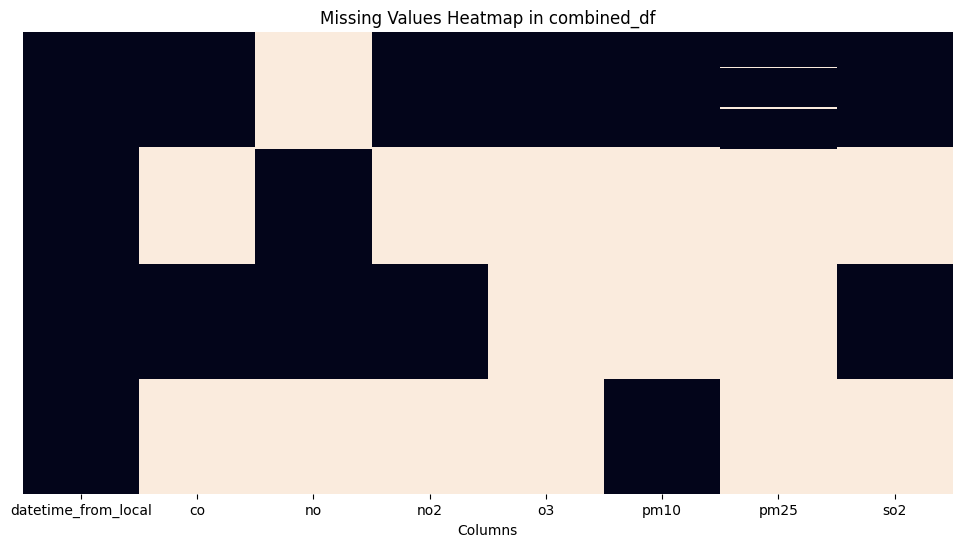

In [198]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_df.isnull(), 
            cbar=False, 
            cmap="rocket", 
            yticklabels=False)

plt.title("Missing Values Heatmap in combined_df")
plt.xlabel("Columns")
plt.show()

In [199]:
missing_percent = combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

parameter_name
pm25                   75.124378
o3                     75.124378
co                     50.248756
no                     50.248756
pm10                   50.248756
no2                    50.248756
so2                    50.248756
datetime_from_local     0.000000
dtype: float64


Due to the significant amount of missing data for all pollutants and considering there may be alternative ways to insert data through requests that I have not yet discovered after the first week of the open programme, I decided to download the available datasets for each month from each station for the year 2025. This will ensure that the data is more recent.

### AMS Chaika - Varna (part 2)

In [200]:
chaika1 = pandas.read_csv("datasets/openaq_location_2162113_measurments.csv")
chaika1.shape

(3000, 15)

In [201]:
chaika2 = pandas.read_csv("datasets/openaq_location_2162113_measurments (1).csv")
chaika2.shape

(1416, 15)

In [202]:
chaika3 = pandas.read_csv("datasets/openaq_location_2162113_measurments (2).csv")
chaika3.shape

(1857, 15)

In [203]:
chaika4 = pandas.read_csv("datasets/openaq_location_2162113_measurments (3).csv")
chaika4.shape

(1430, 15)

In [204]:
chaika5 = pandas.read_csv("datasets/openaq_location_2162113_measurments (4).csv")
chaika5.shape

(1354, 15)

In [205]:
chaika_dataset = pandas.concat([chaika1, chaika2, chaika3, chaika4, chaika5])

In [206]:
chaika_dataset.shape

(9057, 15)

In [207]:
chaika_dataset = chaika_dataset.pivot_table(
    index="datetimeLocal",
    columns="parameter",
    values="value"
).reset_index()

chaika_dataset

parameter,datetimeLocal,co,no2,so2
0,2025-01-01T20:00:00+02:00,1450.0,26.41,20.61
1,2025-01-02T01:00:00+02:00,1260.0,22.42,9.25
2,2025-01-02T02:00:00+02:00,1040.0,16.81,8.45
3,2025-01-02T11:00:00+02:00,940.0,22.20,11.81
4,2025-01-02T12:00:00+02:00,960.0,21.99,13.28
...,...,...,...,...
3045,2025-06-19T05:00:00+03:00,560.0,12.22,-1.00
3046,2025-06-19T06:00:00+03:00,560.0,12.20,-1.00
3047,2025-06-19T07:00:00+03:00,540.0,8.39,-1.00
3048,2025-06-19T09:00:00+03:00,540.0,11.03,-1.00


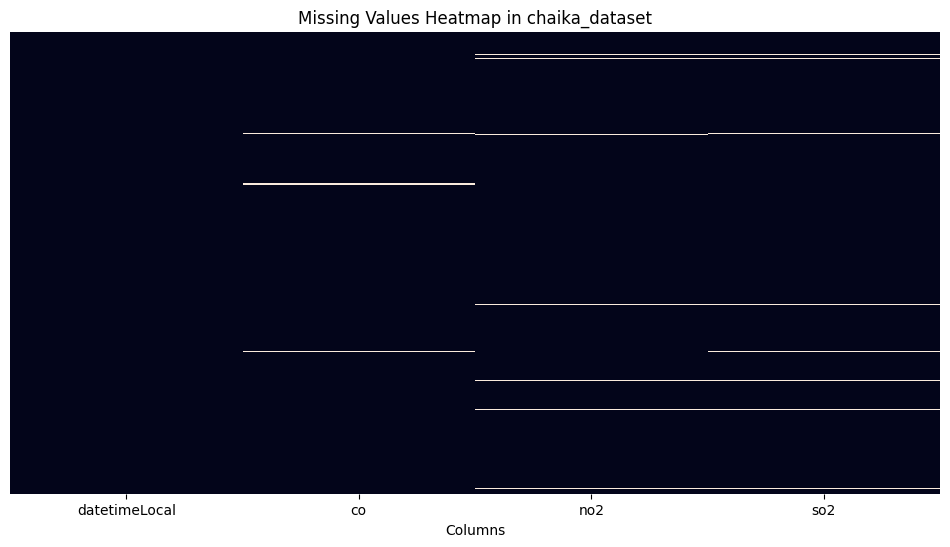

In [208]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(chaika_dataset.isnull(), 
            cbar=False, 
            cmap="rocket", 
            yticklabels=False)

plt.title("Missing Values Heatmap in chaika_dataset")
plt.xlabel("Columns")
plt.show()

What is noticeable here is that although there is little data missing, not all pollutants from the previous dataset are present.

### Angel Kanchev-Varna (part 2)
Let"s do the same here for the next station.

In [209]:
angel1 = pandas.read_csv("datasets/openaq_location_8843_measurments.csv")
angel1.shape

(6000, 15)

In [210]:
angel2 = pandas.read_csv("datasets/openaq_location_8843_measurments (1).csv")
angel2.shape

(2829, 15)

In [211]:
angel3 = pandas.read_csv("datasets/openaq_location_8843_measurments (2).csv")
angel3.shape

(3727, 15)

In [212]:
angel4 = pandas.read_csv("datasets/openaq_location_8843_measurments (3).csv")
angel4.shape

(2871, 15)

In [213]:
angel5 = pandas.read_csv("datasets/openaq_location_8843_measurments (4).csv")
angel5.shape

(2724, 15)

In [214]:
angel_dataset = pandas.concat([angel1, angel2, angel3, angel4, angel5])

In [215]:
angel_dataset.shape

(18151, 15)

In [216]:
angel_dataset = angel_dataset.pivot_table(
    index="datetimeLocal",
    columns="parameter",
    values="value"
).reset_index()

angel_dataset

parameter,datetimeLocal,co,no2,o3,pm10,pm25,so2
0,2025-01-01T20:00:00+02:00,1180.0,95.40,7.74,51.87,51.69,16.57
1,2025-01-02T01:00:00+02:00,490.0,34.49,37.32,44.20,12.47,16.00
2,2025-01-02T02:00:00+02:00,570.0,52.76,19.50,37.13,16.54,16.01
3,2025-01-02T11:00:00+02:00,650.0,70.78,25.91,34.11,21.86,16.45
4,2025-01-02T12:00:00+02:00,720.0,80.30,24.58,35.74,27.21,16.53
...,...,...,...,...,...,...,...
3070,2025-06-19T05:00:00+03:00,350.0,7.46,50.75,10.97,5.82,10.19
3071,2025-06-19T06:00:00+03:00,350.0,7.30,46.95,8.71,5.20,11.06
3072,2025-06-19T07:00:00+03:00,330.0,15.55,41.18,12.10,5.40,10.68
3073,2025-06-19T09:00:00+03:00,720.0,107.43,9.54,20.52,8.29,10.64


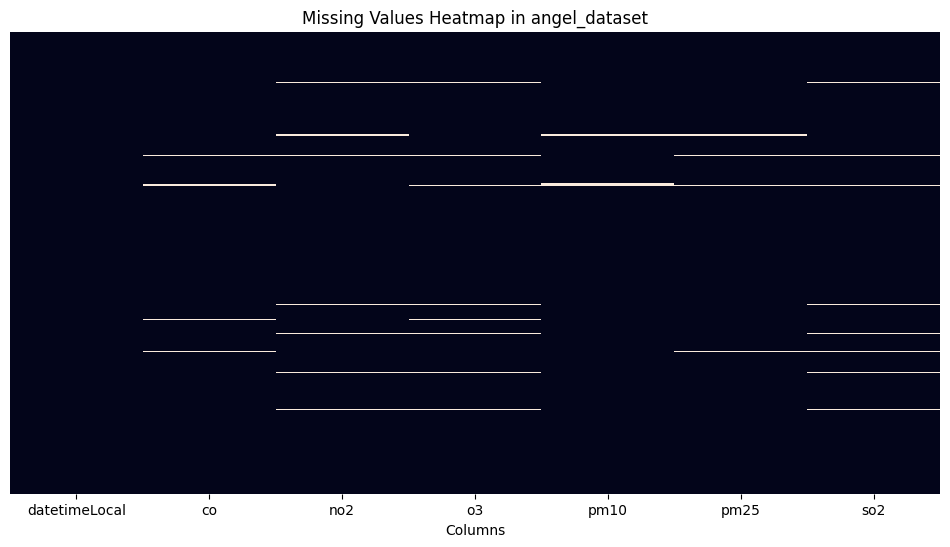

In [217]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(angel_dataset.isnull(), 
            cbar=False, 
            cmap="rocket", 
            yticklabels=False)

plt.title("Missing Values Heatmap in angel_dataset")
plt.xlabel("Columns")
plt.show()

Compared to the previous dataset from Chaika, there are more pollutants, but some are still missing. 

Let's combine all of them to see the final result.

## Combination of all CSV files 📥

In [218]:
final_combined_df = pandas.concat([chaika_dataset, angel_dataset, combined_df])

In [219]:
print("The API key and csv file datasets contain: " + str(final_combined_df.shape))

The API key and csv file datasets contain: (6527, 9)


In [220]:
final_combined_df.sample(10)

,datetimeLocal,co,no2,so2,o3,pm10,pm25,datetime_from_local,no
1931,2025-04-13T13:00:00+03:00,650.0,29.65,8.93,65.48,35.69,14.67,NaN,NaN
170,2025-01-09T17:00:00+02:00,NaN,NaN,NaN,NaN,43.63,NaN,NaN,NaN
286,NaN,480.0,3.51,9.65,NaN,NaN,NaN,2024-02-02T07:00:00+02:00,1.7
1554,2025-03-26T16:00:00+02:00,610.0,8.28,9.26,NaN,NaN,NaN,NaN,NaN
2908,2025-06-09T02:00:00+03:00,510.0,19.92,-1.00,NaN,NaN,NaN,NaN,NaN
458,2025-01-27T03:00:00+02:00,490.0,9.81,17.59,28.66,14.06,8.28,NaN,NaN
1112,2025-03-04T21:00:00+02:00,-1000.0,-1.00,-1.00,-1.00,-1.00,-1.00,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-01T14:00:00+03:00,4.8
1340,2025-03-16T08:00:00+02:00,590.0,9.46,10.92,NaN,NaN,NaN,NaN,NaN
2312,2025-05-08T00:00:00+03:00,480.0,10.67,11.52,NaN,NaN,NaN,NaN,NaN


## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the final key variables used in this dataset:

| No. | Column Name                 | Unit                  | Description                                                                 |
|-----|-----------------------------|-----------------------|-----------------------------------------------------------------------------|
| 1   | `co`                        | parts per million(ppm)| Concentration of carbon monoxide (CO).                                      |
| 2   | `no2`                       | µg/m³                 | Concentration of nitrogen dioxide (NO₂).                                    |
| 3   | `so2`                       | µg/m³                 | Concentration of sulfur dioxide (SO₂).                                      |
| 4   | `o3`                        | µg/m³                 | Concentration of ozone (O₃).                                                |
| 5   | `pm10`                      | µg/m³                 | Concentration of particulate matter (PM₁₀).                                 |
| 6   | `pm25`                      | µg/m³                 | Concentration of particulate matter (PM₂.₅).                                |
| 7   | `no`                        | µg/m³                 | Concentration of nitrogen monoxide (NO).                                    |
| 8   | `datetimeLocal/datetime_from_local` | datetime      | Local date and time of the measurement.                                     |
| 9   | `AQI`                       | unitless              | Air Quality Index (AQI) value calculated based on pollutant concentrations. |
| 10  | `AQI_Category`              | categorical           | Qualitative category of air quality based on AQI values.                    |

⚠️ Not all variables were used in the final model. Several columns were excluded during the cleaning and feature selection process due to missing values, low variance, or low correlation with the target variable (see EDA section for justification).

## Preprocessing 🛠️

### Format dates 🗓️

It is evident that the columns "datetimeLocal" and "datetime_from_local" cannot co-exist since they represent the same data. Therefore, it is logical to combine them into a single column.

In [221]:
final_combined_df["datetime_local"] = final_combined_df["datetime_from_local"].combine_first(final_combined_df["datetimeLocal"])
final_combined_df.drop(columns=["datetime_from_local", "datetimeLocal"], inplace=True)

In [222]:
final_combined_df.dtypes

co                float64
no2               float64
so2               float64
o3                float64
pm10              float64
pm25              float64
no                float64
datetime_local     object
dtype: object

In [223]:
final_combined_df["datetime_local"] = pandas.to_datetime(final_combined_df["datetime_local"], utc=True)
print(final_combined_df.dtypes)

co                            float64
no2                           float64
so2                           float64
o3                            float64
pm10                          float64
pm25                          float64
no                            float64
datetime_local    datetime64[ns, UTC]
dtype: object


In [224]:
final_combined_df["datetime_local"] = pandas.to_datetime(final_combined_df["datetime_local"], errors="coerce")
final_combined_df["datetime_local"] = final_combined_df["datetime_local"].dt.strftime("%Y-%m-%d %H:%M")

In [225]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,no,datetime_local
658,640.0,8.91,6.80,NaN,NaN,NaN,NaN,2025-02-06 07:00
1668,-1000.0,-1.00,-1.00,-1.00,20.12,9.81,NaN,2025-03-31 09:00
2731,550.0,9.09,-1.00,NaN,NaN,NaN,NaN,2025-05-29 16:00
157,1010.0,11.91,11.94,NaN,NaN,NaN,NaN,2025-01-09 01:00
2075,530.0,33.96,10.14,58.24,21.76,11.99,NaN,2025-04-19 21:00
303,NaN,NaN,NaN,NaN,-1.00,NaN,NaN,2024-03-23 15:00
935,440.0,16.38,18.97,57.40,8.36,2.16,NaN,2025-02-18 08:00
693,400.0,2.28,19.03,48.16,10.97,7.25,NaN,2025-02-07 09:00
1029,440.0,4.04,19.44,73.47,24.36,14.01,NaN,2025-02-23 01:00
1099,500.0,17.63,12.05,72.77,22.70,11.18,NaN,2025-02-28 22:00


### Null values 0️⃣

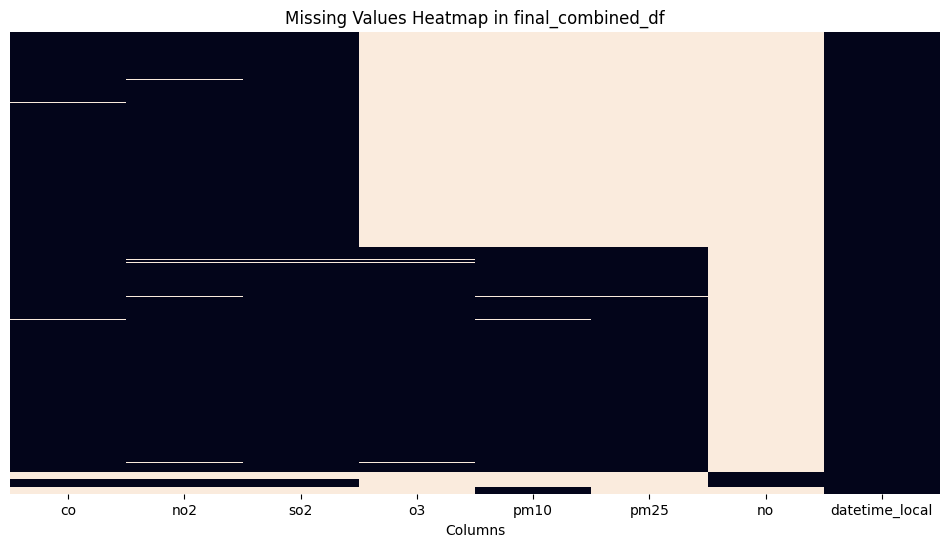

In [226]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap="rocket", 
            yticklabels=False)

plt.title("Missing Values Heatmap in final_combined_df")
plt.xlabel("Columns")
plt.show()

In [227]:
missing_percent = final_combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

no                96.935805
o3                52.290486
pm25              52.014708
pm10              50.375364
no2                4.703539
so2                4.473725
co                 3.968132
datetime_local     0.000000
dtype: float64


Since **nitric oxide (NO)** is missing in nearly 97% of the dataset, I believe it is not very important and should not be included. I will only retain values that have a presence of more than 30% in the dataset, as those have a valid reason for being kept. Even partial data can capture trends or patterns.

To better understand each value, I will explain them one by one, chemical by chemical:

**PM2.5 (Fine Particulate Matter)**
- One of the most dangerous air pollutants. Often a major driver of AQI values.
- Can penetrate deep into the lungs and even enter the bloodstream. Linked to respiratory and cardiovascular diseases, premature death and cancer.

**PM10 (Inhalable Particulate Matter)**
- Can cause respiratory irritation, lung function decline and worsen conditions like asthma and bronchitis.

**O₃ (Ground-level Ozone)**
- Not emitted directly; formed by chemical reactions between NOx and VOCs in sunlight.
- Causes chest pain, coughing, throat irritation, and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, can be fatal at very high levels; particularly dangerous indoors.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO₂ (Nitrogen Dioxide)**
- Combustion engines (cars, trucks, etc), power plants.
- Irritates airways, reduces lung function, and increases the risk of respiratory infections.
- Key indicator of traffic-related air pollution; contributes to the formation of PM and ozone.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Less directly harmful, but quickly converts into **NO₂**, which is more dangerous.

So since we have enough of the **NO₂**, discarding **NO** is fine, due to the following reasons:
- **NO** and **NO₂** are chemically linked and often reported together as NOx (nitrogen oxides).
- **NO₂** is the more harmful and relevant pollutant for health and AQI. It is usually used directly in AQI calculation, not **NO**.
- **NO** is a precursor to **NO₂** and ozone, but if you already have **NO₂** (which reflects both traffic-related emissions and photochemical activity), we are already capturing the more critical part of the picture.

sources: 
- https://ww2.arb.ca.gov/resources/nitrogen-dioxide-and-health#:~:text=Air%20quality%20regulators%20have%20selected,X%20emissions%20as%20a%20group
- https://en.wikipedia.org/wiki/NOx#:~:text=In%20atmospheric%20chemistry%2C%20the%20term,to%20again%20form%20NO%202

In [228]:
threshold = 0.7
final_combined_df = final_combined_df.loc[:, final_combined_df.isnull().mean() < threshold]

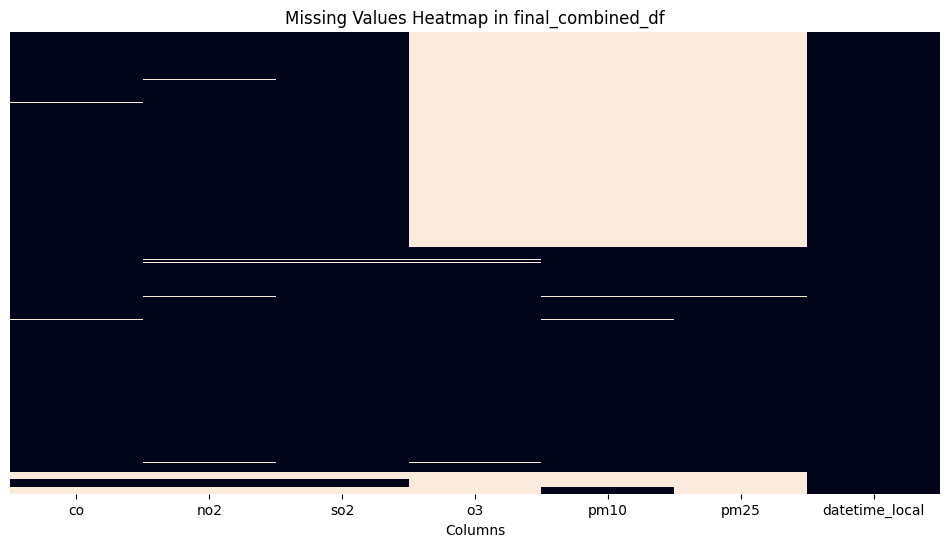

In [229]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap="rocket", 
            yticklabels=False)

plt.title("Missing Values Heatmap in final_combined_df")
plt.xlabel("Columns")
plt.show()

In [230]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local
1544,470.0,29.16,10.86,51.03,52.86,11.40,2025-03-24 21:00
1146,1210.0,23.98,10.43,NaN,NaN,NaN,2025-03-07 01:00
354,500.0,35.79,17.10,7.60,16.64,13.46,2025-01-22 05:00
172,NaN,NaN,NaN,NaN,40.90,NaN,2025-01-09 17:00
289,520.0,3.58,10.35,NaN,NaN,NaN,2024-02-02 08:00
2049,450.0,7.21,9.06,NaN,NaN,NaN,2025-04-19 11:00
1024,560.0,8.57,8.93,NaN,NaN,NaN,2025-02-23 12:00
1403,330.0,7.53,11.04,51.89,2.19,1.22,2025-03-18 10:00
2484,480.0,10.62,-1.00,NaN,NaN,NaN,2025-05-15 20:00
1463,1040.0,121.11,8.92,15.02,45.16,27.18,2025-03-21 07:00


Since several key features like **O₃**, **PM2.5** and **PM10** have more than 50% missing values, we apply mean imputation to handle missing values in key pollutant features, ensuring dataset completeness while preserving the overall data distribution for model training.

In [231]:
# imputer = SimpleImputer(strategy="mean") 
# final_combined_df[["co", "no2", "so2", "o3", "pm10", "pm25"]] = imputer.fit_transform(
#     final_combined_df[["co", "no2", "so2", "o3", "pm10", "pm25"]]
# )

After testing the models, I found overfitting due to imputation. To prevent this, I decided to drop the non-value data instead. That is why I commented the block of code.

In [232]:
final_combined_df = final_combined_df.dropna(subset=["co", "no2", "so2", "o3", "pm10", "pm25"])

In [233]:
final_combined_df.isnull().sum()

co                0
no2               0
so2               0
o3                0
pm10              0
pm25              0
datetime_local    0
dtype: int64

Finally, here is the result no missing values.

The issue with the missing data arises from the outdated measurments provided by the API key, as well as the fact that both stations do not collect the same measurements. To address this, I utilized the CSV files. The data for 2025 is much more complete and up-to-date, making it a better choice for the model and the final results.

## Sample the data 📃

In [234]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local
1856,600.0,40.46,9.21,41.04,30.68,13.45,2025-04-10 03:00
1492,490.0,9.97,9.04,84.79,20.46,7.35,2025-03-22 14:00
495,930.0,162.15,19.46,7.54,49.17,34.22,2025-01-28 16:00
2463,470.0,36.31,4.40,21.08,10.51,8.32,2025-05-13 22:00
1668,-1000.0,-1.00,-1.00,-1.00,20.12,9.81,2025-03-31 09:00
824,530.0,16.79,18.62,48.61,53.54,18.58,2025-02-13 10:00
2403,410.0,23.26,3.73,30.91,11.17,8.57,2025-05-11 06:00
1105,540.0,10.87,12.03,58.28,7.68,4.47,2025-03-02 15:00
909,400.0,1.09,19.29,60.81,6.12,0.48,2025-02-17 04:00
2563,390.0,12.65,6.47,43.83,8.68,3.21,2025-05-20 08:00


## Calculating AQI 🧮
At the moment there is no present target variable from this data, however the data is enough to calculate the AQI sub-index for a given pollutant concentration, based on a list of breakpoint ranges. Then, it rounds the result to the nearest whole number (since AQI is usually reported as an integer). If no breakpoint matches, it returns None

In [235]:
def get_subindex(concentration, breakpoints):
    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= concentration <= Chigh:
            return round((Ihigh - Ilow) / (Chigh - Clow) * (concentration - Clow) + Ilow)
    return None

The following block defines breakpoints for the air pollutants. These are used to map pollutant concentration levels to AQI sub-index values, according to air quality standards. 

Each list of breakpoints contains tuples with 4 values:

**(Concentration_low, Concentration_high, AQI_low, AQI_high)**

These represent a range of pollutant concentration values and the corresponding AQI values.

I got it from United States Environmental Protection Agency (https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [236]:
pm25_breakpoints = [
    (0.0, 9.0, 0, 50),             # Good
    (9.1, 35.4, 51, 100),          # Moderate
    (35.5, 55.4, 101, 150),        # Unhealthy for sensitive groups
    (55.5, 125.4, 151, 200),       # Unhealthy
    (125.5, 225.4, 201, 300),      # Very Unhealthy
    (225.5, 325.4, 301, 400),      # Hazardous
    (325.5, 99999.9, 401, 500)     # Extended Hazardous
]
pm10_breakpoints = [
    (0, 54, 0, 50),                # Good
    (55, 154, 51, 100),            # Moderate
    (155, 254, 101, 150),          # Unhealthy for sensitive groups
    (255, 354, 151, 200),          # Unhealthy
    (355, 424, 201, 300),          # Very Unhealthy
    (425, 604, 301, 500),          # Hazardous
    (605, 99999.9, 501, 999)       # Extended Hazardous
]
o3_breakpoints = [      
    (0, 54, 0, 50),                # Good    
    (55, 70, 51, 100),             # Moderate    
    (71, 85, 101, 150),            # Unhealthy for sensitive groups  
    (86, 105, 151, 200),           # Unhealthy
    (106, 200, 201, 300)           # Very Unhealthy
]
co_breakpoints = [
    (0.0, 4.4, 0, 50),             # Good
    (4.5, 9.4, 51, 100),           # Moderate
    (9.5, 12.4, 101, 150),         # Unhealthy for sensitive groups
    (12.5, 15.4, 151, 200),        # Unhealthy
    (15.5, 30.4, 201, 300),        # Very Unhealthy
    (30.5, 50.4, 301, 500),        # Hazardous
    (50.5, 99999.9, 501, 999)      # Extended Hazardous
]
no2_breakpoints = [
    (0, 53, 0, 50),                # Good
    (54, 100, 51, 100),            # Moderate
    (101, 360, 101, 150),          # Unhealthy for sensitive groups
    (361, 649, 151, 200),          # Unhealthy
    (650, 1249, 201, 300),         # Very Unhealthy
    (1250, 2049, 301, 500),        # Hazardous
    (2050, 99999, 501, 999)        # Extended Hazardous
]
so2_breakpoints = [
    (0, 35, 0, 50),                # Good
    (36, 75, 51, 100),             # Moderate
    (76, 185, 101, 150),           # Unhealthy for sensitive groups
    (186, 304, 151, 200),          # Unhealthy
    (305, 99999, 201, 300)         # Very Unhealthy
]

To quantify overall air quality, we calculate the AQI for each row based on six key pollutants: PM2.5, PM10, O₃, CO, NO₂ and SO₂. For each pollutant, we compute a sub-index AQI using EPA-defined breakpoints and a standard formula that linearly maps pollutant concentrations to the AQI scale. 

CO concentrations are converted from µg/m³ to mg/m³ to match the units of its breakpoints. 

Only non-missing pollutant values are considered and the final AQI for each row is determined by taking the maximum of the available sub-indices, reflecting the pollutant posing the greatest health risk at that point in time. This process results in a single AQI value per observation, representing the overall air quality based on the most harmful pollutant present.

In [237]:
def calculate_row_aqi(row):
    aqi_values = []
    
    if not pandas.isnull(row["pm25"]):
        aqi_values.append(get_subindex(row["pm25"], pm25_breakpoints))
    if not pandas.isnull(row["pm10"]):
        aqi_values.append(get_subindex(row["pm10"], pm10_breakpoints))
    if not pandas.isnull(row["o3"]):
        aqi_values.append(get_subindex(row["o3"], o3_breakpoints))
    if not pandas.isnull(row["co"]):
        aqi_values.append(get_subindex(row["co"] / 1000, co_breakpoints))  # µg/m³ to mg/m³
    if not pandas.isnull(row["no2"]):
        aqi_values.append(get_subindex(row["no2"], no2_breakpoints))
    if not pandas.isnull(row["so2"]):
        aqi_values.append(get_subindex(row["so2"], so2_breakpoints))
    
    return max([aqi for aqi in aqi_values if aqi is not None], default=None)

final_combined_df["AQI"] = final_combined_df.apply(calculate_row_aqi, axis=1)

To make the AQI values more interpretable, we classify them into standard health-related categories using this function, which assigns each AQI to a label based on U.S. EPA guidelines (https://www3.epa.gov/ttn/ozonehealth/figure14.html).

The result is stored in a new column called "AQI_Category", making it easy to group and visualize air quality conditions across different records.

In [238]:
def aqi_category(aqi):
    if aqi is None:
        return "Unknown"
    elif aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

final_combined_df["AQI_Category"] = final_combined_df["AQI"].apply(aqi_category)

In [239]:
final_combined_df["AQI_Category"].value_counts()

AQI_Category
Moderate                          1492
Unhealthy for Sensitive Groups     556
Good                               497
Unhealthy                          327
Hazardous                          152
Very Unhealthy                      57
Name: count, dtype: int64

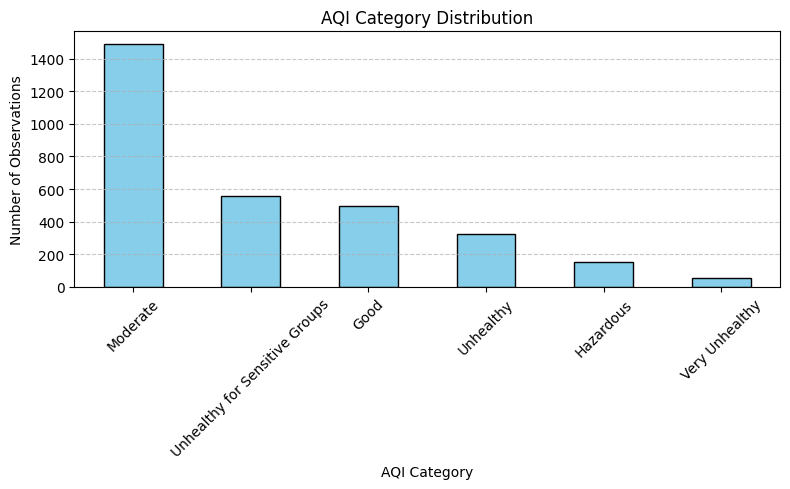

In [240]:
category_counts = final_combined_df["AQI_Category"].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("AQI Category Distribution")
plt.xlabel("AQI Category")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


The "Moderate" AQI category has the highest number of observations, which is a common outcome in urban air quality datasets. This reflects typical, day-to-day air conditions where pollutant levels are elevated due to vehicle traffic, household activities and mild industrial emissions, but not high enough to trigger health warnings for the general population. In many environments, especially outside of extreme weather events or major pollution incidents, air quality tends to fluctuate within this moderate range. This suggests that while the air may not be perfectly clean, it is generally acceptable for most people, with only limited risk for sensitive individuals.

In [241]:
final_combined_df.isnull().sum()

co                  0
no2                 0
so2                 0
o3                  0
pm10                0
pm25                0
datetime_local      0
AQI               152
AQI_Category        0
dtype: int64

In [242]:
final_combined_df = final_combined_df.dropna(subset=["AQI"])

In [243]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local,AQI,AQI_Category
666,400.0,0.97,20.58,39.72,6.55,5.12,2025-02-06 03:00,37.0,Good
2226,400.0,10.78,11.12,97.42,16.37,5.24,2025-04-28 13:00,180.0,Unhealthy
1888,470.0,10.22,9.56,90.46,9.59,3.26,2025-04-11 12:00,163.0,Unhealthy
47,480.0,12.46,16.65,34.40,13.49,0.63,2025-01-04 06:00,32.0,Good
1653,420.0,20.25,7.52,73.74,28.27,12.37,2025-03-30 14:00,111.0,Unhealthy for Sensitive Groups
2859,370.0,42.09,12.06,36.57,12.09,11.12,2025-06-03 21:00,55.0,Moderate
1204,960.0,120.19,14.01,13.32,72.89,38.44,2025-03-08 23:00,108.0,Unhealthy for Sensitive Groups
482,440.0,8.79,18.59,19.08,42.88,13.52,2025-01-28 02:00,59.0,Moderate
1867,420.0,15.61,10.43,99.35,29.11,7.02,2025-04-10 14:00,185.0,Unhealthy
1754,450.0,14.63,9.45,66.66,22.37,10.52,2025-04-04 23:00,89.0,Moderate


## Data Analysis and Visualization 📊

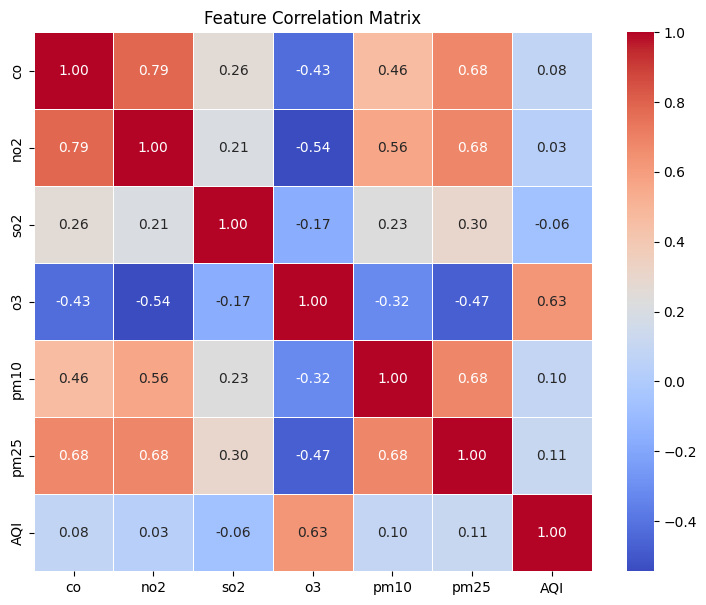

In [244]:
numeric_df = final_combined_df.select_dtypes(include="number")
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(9, 7))
seaborn.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Matrix")
plt.show()

This is a correlation matrix heatmap showing the relationships between various air quality features: carbon monoxide (co), nitrogen dioxide (no2), sulfur dioxide (so2), ozone (o3), particulate matter ≤10μm (pm10), particulate matter ≤2.5μm (pm25) and the Air Quality Index (AQI). Each cell contains the Pearson correlation coefficient between two features, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). Red shades indicate strong positive correlations, blue shades indicate strong negative correlations and neutral colors show weak or no correlation.

**Key observations:**
- co and no2 have a strong positive correlation (0.79), meaning they tend to increase or decrease together.
- pm10 and pm25 are also strongly positively correlated (0.68), reflecting their similar sources and behavior.
- o3 is negatively correlated with no2 (-0.54) and pm25 (-0.47), indicating that as ozone increases, these pollutants tend to decrease.
- AQI has a moderate positive correlation with o3 (0.63), suggesting ozone levels significantly influence air quality in this dataset.
- Other correlations, such as AQI with co, no2, so2, pm10 and pm25, are weak (close to zero).

This matrix helps identify which pollutants are closely related, which can inform air quality analysis and modeling.

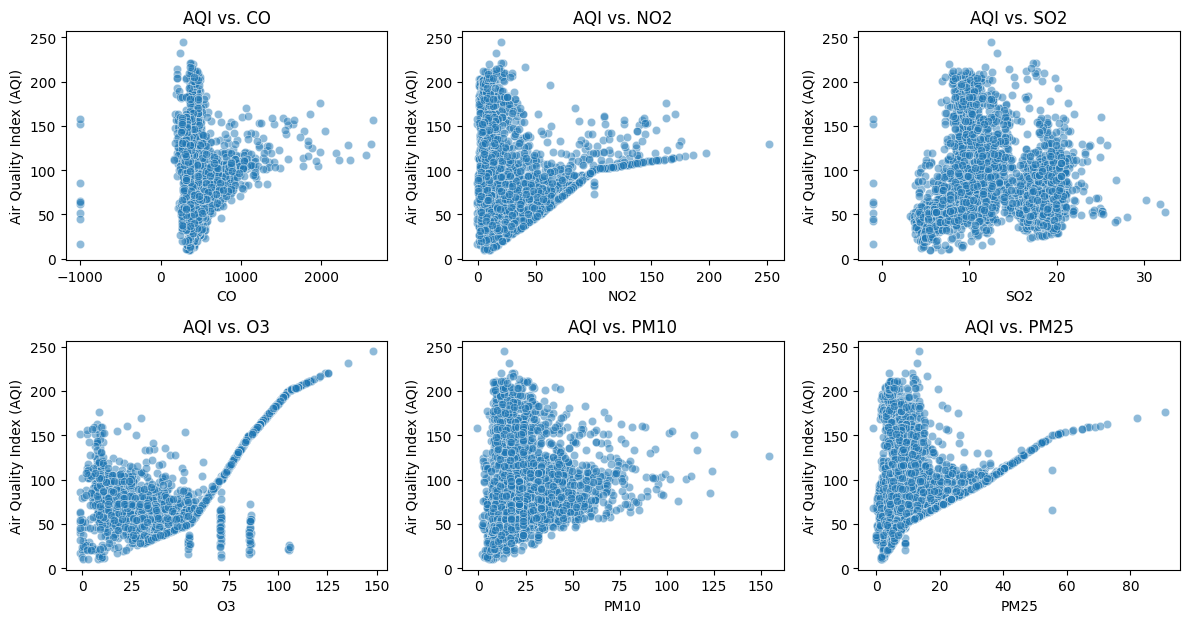

In [245]:
air_quality_features = ["co", "no2", "so2", "o3", "pm10", "pm25"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axes = axes.flatten()

for i, feature in enumerate(air_quality_features):
    seaborn.scatterplot(
        x=final_combined_df[feature],
        y=final_combined_df["AQI"], 
        alpha=0.5,
        ax=axes[i] 
    )
    axes[i].set_xlabel(feature.upper())
    axes[i].set_ylabel("Air Quality Index (AQI)")
    axes[i].set_title(f"AQI vs. {feature.upper()}")

for j in range(len(air_quality_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

These scatter plots show the relationship between the Air Quality Index (AQI) and six air pollutants: carbon monoxide (CO), nitrogen dioxide (NO2), sulfur dioxide (SO2), ozone (O3), particulate matter ≤10μm (PM10) and particulate matter ≤2.5μm (PM25). Each point represents a data sample, with the pollutant concentration on the x-axis and the AQI value on the y-axis.

**Key observations:**
- CO (Carbon Monoxide): The points are widely scattered and form a triangular pattern, suggesting there is no strong or consistent relationship between CO levels and AQI in this dataset.
- NO2 (Nitrogen Dioxide): Similar to CO, the data points are spread out in a triangular shape, indicating only a weak or inconsistent relationship between NO2 and AQI.
- SO2 (Sulfur Dioxide): The points are clustered without a clear trend, showing little to no direct relationship between SO2 and AQI.
- O3 (Ozone): There is a noticeable upward trend, especially at higher ozone levels. As O3 increases, AQI also tends to increase, indicating a stronger positive relationship compared to the other pollutants.
- PM10 (Particulate Matter ≤10μm): The scatter is wide and triangular, showing a weak relationship between PM10 and AQI.
- PM25 (Particulate Matter ≤2.5μm): The pattern is similar to PM10, with a wide spread of AQI values for most PM25 concentrations, indicating a weak relationship.

Overall, these plots indicate that among the pollutants shown, ozone (O3) has the strongest visible association with AQI, while the others show weaker or less clear relationships. This suggests that, in this dataset, AQI is most sensitive to changes in ozone levels.